In [316]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
import nrrd

In [317]:
radiomics_features_dir = os.path.join(os.path.dirname(os.getcwd()),"data", "radiomics_features_updated.csv")
radiomics_df= pd.read_csv(radiomics_features_dir)

radiomics_df["TCIA_ID"] = radiomics_df["Subject ID_x"]
radiomics_df = radiomics_df.drop(columns=["Subject ID_x"])
# len(radiomics_df["Subject ID"].unique())

In [318]:
def remove_diagnostic_cols(df):
    copy = df.copy()
    retained_cols = []
    for column in copy.columns:
        if "diagnostics" in column:
            continue

        retained_cols.append(column)

    return copy[retained_cols]

radiomics_df = remove_diagnostic_cols(radiomics_df)



In [319]:
clin_df = pd.read_csv("clinical_df_cleaned_fix.csv")

radiomics_df_merged = pd.merge(
    left=radiomics_df,
    right= clin_df[["TCIA_ID", "responder"]],
    on="TCIA_ID",
    how="left"
)

# Assuming 'radiomics_df_merged' is the original DataFrame containing all features and metadata

# 1. Separate the metadata columns
metadata_cols = ["TCIA_ID", "responder"] 
metadata = radiomics_df_merged[metadata_cols].copy()

# 2. Drop metadata to isolate ONLY radiomics features
radiomics_features = radiomics_df_merged.drop(columns=metadata_cols, errors='ignore').copy()

# 3. Filter the features to keep ONLY those containing 'pv'
radiomics_features_pv = radiomics_features

# 4. Handle missing subjects (rows) by dropping any rows that are all NaN across PV features
radiomics_df_final = radiomics_features_pv

# 5. Concatenate the filtered PV features with the aligned metadata columns
# NOTE: We use .loc[] to ensure the metadata only includes subjects that survived the dropna step (row alignment).
metadata_aligned = metadata.loc[radiomics_df_final.index].drop(columns=['Unnamed: 0'], errors='ignore')
radiomics_df_final = pd.concat([radiomics_df_final, metadata_aligned], axis=1).reset_index(drop=True)

# radiomics_df_final now contains ONLY PV features + TCIA_ID + responder



In [320]:
non_multiphase_df = pd.read_csv("non_multiphase_joined_fixed.csv")

non_multiphase_patients = non_multiphase_df["Subject ID"].unique()

non_multiphase_patients

array(['HCC_004', 'HCC_005', 'HCC_006', 'HCC_009', 'HCC_012', 'HCC_013',
       'HCC_014', 'HCC_015', 'HCC_016', 'HCC_017', 'HCC_018', 'HCC_019',
       'HCC_020', 'HCC_021', 'HCC_022', 'HCC_023', 'HCC_024', 'HCC_025',
       'HCC_026', 'HCC_027', 'HCC_028', 'HCC_029', 'HCC_031', 'HCC_032',
       'HCC_033', 'HCC_034', 'HCC_035', 'HCC_036', 'HCC_037', 'HCC_038',
       'HCC_039', 'HCC_040', 'HCC_041', 'HCC_042', 'HCC_043', 'HCC_044',
       'HCC_045', 'HCC_046', 'HCC_047', 'HCC_048', 'HCC_049', 'HCC_050',
       'HCC_051', 'HCC_052', 'HCC_053', 'HCC_054', 'HCC_055', 'HCC_056',
       'HCC_057', 'HCC_058', 'HCC_059', 'HCC_060', 'HCC_061', 'HCC_062',
       'HCC_063', 'HCC_064', 'HCC_065', 'HCC_066', 'HCC_067', 'HCC_069',
       'HCC_070', 'HCC_071', 'HCC_072', 'HCC_073', 'HCC_074', 'HCC_075',
       'HCC_076', 'HCC_077', 'HCC_078', 'HCC_079', 'HCC_080', 'HCC_081',
       'HCC_082', 'HCC_083', 'HCC_084', 'HCC_085', 'HCC_086', 'HCC_087',
       'HCC_088', 'HCC_089', 'HCC_090', 'HCC_098'],

In [321]:
# radiomics_df_final = radiomics_df_final[radiomics_df_final["TCIA_ID"].isin(non_multiphase_patients)]

In [322]:
multiphase_extraction_fixed_df = pd.read_csv("multiphase_radiomic_features_pv_aligned_v2_WAVELET.csv")

used_cols =  [col for col in multiphase_extraction_fixed_df.columns if ("delayed" not in col) and ("diagnostics" not in col)]

multiphase_extraction_fixed_df = multiphase_extraction_fixed_df[used_cols]

In [323]:
# multiphase_extraction_fixed_df

In [324]:
multiphase_extraction_fixed_df = pd.merge(
    left=multiphase_extraction_fixed_df, 
    right = clin_df[["responder", "TCIA_ID"]], 
    left_on="Subject ID",
    right_on="TCIA_ID",
    how = "left",
    validate="one_to_one"
)

multiphase_extraction_fixed_df = multiphase_extraction_fixed_df.drop(columns=["Subject ID"])

In [325]:
common_cols = radiomics_df_final.columns.intersection(multiphase_extraction_fixed_df.columns)

radiomics_df_final = pd.concat(
    [radiomics_df_final[common_cols], multiphase_extraction_fixed_df[common_cols]],
    axis = 0
)




In [326]:
radiomics_df_final = radiomics_df_final.sort_values("TCIA_ID").reset_index()

drop_cases = (set(clin_df["TCIA_ID"].unique())).difference(set(radiomics_df_final["TCIA_ID"].unique()))
clin_df = clin_df[clin_df["TCIA_ID"].isin(drop_cases) == False]

clin_df = clin_df.drop(columns=["Unnamed: 0"])

In [327]:
from scipy.stats import ranksums

def is_train_test_difference_significant(x_train, x_test, alpha=0.05):

    x_train = np.asarray(x_train)
    x_test = np.asarray(x_test)
    
    # Flatten arrays if they are multi-dimensional
    if x_train.ndim > 1:
        x_train = x_train.ravel()
    if x_test.ndim > 1:
        x_test = x_test.ravel()
    
    # Perform the Wilcoxon rank-sum test
    stat, p_value = ranksums(x_train, x_test)
    
    # Check if the difference is statistically significant
    is_significant = p_value < alpha

    
    
    return is_significant, p_value

In [328]:
# radiomics_df_final.to_csv("radiomics_df_final.csv")

In [329]:
# non_empty_rows = radiomics_df_final["responder"].dropna().index

# radiomics_df_final = radiomics_df_final.loc[non_empty_rows]

# radiomics_df_final

In [330]:
parent_path = os.path.dirname(os.getcwd())

print(parent_path)
data_df = pd.read_csv(os.path.join(parent_path, "data", "combined_data.csv"))


c:\Users\Kevin Hadinata\Downloads\Pipeline


In [331]:
radiomics_df_final

,index,pre-contrast_Liver_original_shape_Elongation,pre-contrast_Liver_original_shape_Flatness,pre-contrast_Liver_original_shape_LeastAxisLength,pre-contrast_Liver_original_shape_MajorAxisLength,pre-contrast_Liver_original_shape_Maximum2DDiameterColumn,pre-contrast_Liver_original_shape_Maximum2DDiameterRow,pre-contrast_Liver_original_shape_Maximum2DDiameterSlice,pre-contrast_Liver_original_shape_Maximum3DDiameter,pre-contrast_Liver_original_shape_MeshVolume,...,pv_Mass_wavelet-LLL_gldm_HighGrayLevelEmphasis,pv_Mass_wavelet-LLL_gldm_LargeDependenceEmphasis,pv_Mass_wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis,pv_Mass_wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,pv_Mass_wavelet-LLL_gldm_LowGrayLevelEmphasis,pv_Mass_wavelet-LLL_gldm_SmallDependenceEmphasis,pv_Mass_wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,pv_Mass_wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,TCIA_ID,responder
0,0,0.645410,0.477498,100.049160,209.528005,213.459598,171.493440,227.431308,261.969464,1.467114e+06,...,323.478033,100.411544,32958.040375,0.319722,0.003608,0.040015,10.804820,0.000357,HCC_001,0.0
1,1,0.742868,0.510477,121.231097,237.485924,289.620441,234.797785,253.503452,290.306734,2.056672e+06,...,299.947959,83.474883,25131.510317,0.285889,0.003501,0.035442,10.631682,0.000135,HCC_002,0.0
2,0,0.771732,0.572528,99.086801,173.068916,196.888293,177.019773,207.870152,208.693555,1.118134e+06,...,173.451880,97.408719,16742.260429,0.638279,0.006948,0.035762,6.409037,0.000285,HCC_004,NaN
3,1,0.601359,0.422171,112.220179,265.816783,262.528094,197.144617,264.491966,280.718720,1.988790e+06,...,378.522208,69.510865,26301.117214,0.323983,0.004359,0.050869,19.009098,0.000263,HCC_005,NaN
4,2,0.820738,0.540868,93.469940,172.814546,211.026065,183.741666,199.484335,211.489952,1.379556e+06,...,212.171066,111.441451,26873.206078,0.673628,0.009091,0.026470,4.564165,0.000519,HCC_006,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8,0.667502,0.511111,107.780906,210.875815,217.623528,183.896710,228.980349,240.279004,1.508755e+06,...,62.919430,85.528667,5351.192716,1.622442,0.020436,0.036283,2.345999,0.000908,NaN,NaN
96,13,0.688019,0.439106,90.640598,206.420776,196.946693,182.258059,237.497368,237.573147,1.381228e+06,...,51.514793,80.841017,2868.913795,3.179799,0.034833,0.061303,5.293543,0.001744,NaN,NaN
97,14,0.563167,0.482570,118.087878,244.706455,253.339693,190.538710,247.315588,266.169119,1.817119e+06,...,725.276886,78.293845,57978.550050,0.114513,0.001955,0.043600,27.944587,0.000170,NaN,NaN
98,16,0.585953,0.556170,125.635970,225.895060,223.986607,194.733151,219.009132,236.683333,1.180692e+06,...,481.638328,95.004761,43184.852988,0.235812,0.002353,0.031848,16.377815,0.000079,NaN,NaN


A/B Testing


combine endpoint and radiomic for initial test


In [332]:
# from tkinter import N
# from sklearn.model_selection import train_test_split

# def train_test_split_patients(
#     dataframe: pd.DataFrame, 
#     identifier: str, 
#     endpoint: str, 
#     test_ratio: float = 0.2,
#     random_state: int = 42
# ):
#     # Get unique patient IDs
#     unique_patients = dataframe[identifier].unique()
    
#     # Split patients into train and test
#     train_patients, test_patients = train_test_split(
#         unique_patients, 
#         test_size=test_ratio,
#         random_state=random_state,
#         stratify=dataframe[endpoint]  # Optional: maintain class balance
#     )
    
#     # Create masks
#     train_mask = dataframe[identifier].isin(train_patients)
#     test_mask = dataframe[identifier].isin(test_patients)
#     cols_to_drop = [endpoint]

#     if identifier != None:
#         cols_to_drop.append(identifier)
#     # Split the data
#     x_train = dataframe[train_mask].drop(columns=cols_to_drop, axis=1)
#     x_test = dataframe[test_mask].drop(columns=cols_to_drop, axis=1)
#     y_train = dataframe[train_mask][endpoint]
#     y_test = dataframe[test_mask][endpoint]

 
#     return x_train, x_test, y_train, y_test


In [333]:
train_test_ratio = 0.3
train_test_seed = 42

In [334]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

def train_test_split_patients(
    dataframe: pd.DataFrame, 
    identifier: str, 
    endpoint: str, 
    test_ratio: float = 0.2,
    random_state: int = 42
):
    """
    Splits a dataframe into train and test sets at the patient level, 
    ensuring stratification based on the patient's final outcome (endpoint).

    Args:
        dataframe (pd.DataFrame): The input data.
        identifier (str): The column name for unique patient IDs.
        endpoint (str): The column name for the classification target/outcome.
        test_ratio (float): The proportion of the data to include in the test split.
        random_state (int): Controls the randomness of the split.
    """
    
    # --- 1. Get unique patients and their associated endpoint ---
    # We assume the 'endpoint' is the same for all rows belonging to one patient.
    # We create a Series where the index is the patient ID and the value is the endpoint.
    # patient_outcomes = dataframe.drop_duplicates(subset=[identifier]).set_index(identifier)[endpoint]
    
    # # Get the unique patient IDs (data to split) and their corresponding outcomes (labels to stratify by)
    # unique_patients = patient_outcomes.index.to_numpy()
    # stratify_labels = patient_outcomes.to_numpy()
    
    # --- 2. Split patients into train and test (Correct Stratification) ---
    train_patients, test_patients = train_test_split(
        dataframe[identifier], 
        test_size=test_ratio,
        random_state=random_state,
        # Now, stratify_labels has the correct length (N_patients) and order 
        # corresponding to the unique_patients array.
        stratify=dataframe[endpoint] 
    )
    
    # --- 3. Create masks and split the full dataframe ---
    train_mask = dataframe[identifier].isin(train_patients)
    test_mask = dataframe[identifier].isin(test_patients)
    
    cols_to_drop = [endpoint]
    if identifier is not None:
        cols_to_drop.append(identifier)


    # Split the data
    x_train = dataframe[train_mask].drop(columns=cols_to_drop, axis=1)
    x_test = dataframe[test_mask].drop(columns=cols_to_drop, axis=1)
    y_train = dataframe[train_mask][endpoint]
    y_test = dataframe[test_mask][endpoint]

    print(f"Train Set Patient Count: {len(train_patients)}")
    print(f"Test Set Patient Count: {len(test_patients)}")

    print(f"Train Set Endpoint Distribution:\n{y_train.value_counts(normalize=True)}")
    print(f"Test Set Endpoint Distribution:\n{y_test.value_counts(normalize=True)}")
    
    return x_train, x_test, y_train, y_test

In [335]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

def classification_metrics(y_true, y_pred):
    """
    Compute common classification metrics for binary classification.
    
    Returns a dictionary with:
    - Accuracy
    - F1 Score
    - Precision
    - Sensitivity (Recall)
    - Specificity
    - Confusion Matrix
    """
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)
    
    # Confusion matrix: [[TN, FP], [FN, TP]]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    metrics_dict = {
        'Accuracy': acc,
        'F1 Score': f1,
        'Precision': precision,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity,
        'Confusion Matrix': confusion_matrix(y_true, y_pred)
    }
    
    return metrics_dict


Standardization of values


In [336]:


from sklearn.base import BaseEstimator, TransformerMixin

class MissingValueColumnFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.3):
        self.threshold = threshold
        self.keep_features_ = None

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        missing_frac = X.isna().mean()
        self.keep_features_ = missing_frac[missing_frac <= self.threshold].index
        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        # Only keep columns selected during fit
        return X[self.keep_features_]


In [337]:
from sklearn.base import BaseEstimator, TransformerMixin

class CleanFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, missing_thresh=0.3, variance_thresh=1e-6):
        self.missing_thresh = missing_thresh
        self.variance_thresh = variance_thresh
        self.keep_cols = []

    def fit(self, X, y=None):

        # print("from clean feature selector : X")
        # print(X)
        X = pd.DataFrame(X, columns=X.columns if hasattr(X, "columns") else None)

        # Drop by missing %
        keep_missing = X.isna().mean() < self.missing_thresh
        X2 = X.loc[:, keep_missing]

        # Drop by variance
        var = X2.var()
        keep_var = var > self.variance_thresh

        self.keep_cols_ = X2.columns[keep_var].tolist()
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=X.columns if hasattr(X, "columns") else None)

        print(X[self.keep_cols_])
        return X[self.keep_cols_]


In [338]:
from scipy.stats import mannwhitneyu, kruskal

class FeatureFilterer:
    def __init__(self, responder_idx, nonresponder_idx, filter_method_name = "mannwhitney", p_val_threshold=0.05):
        self.p_val_threshold = p_val_threshold
        self.responder_idx = responder_idx
        self.nonresponder_idx = nonresponder_idx
        self.filter_method_name = filter_method_name
        self.kept_cols = []

    def fit(self, X, y=None):

        # X is already a DataFrame here if CleanFeatureSelector keeps it that way
        X_df = pd.DataFrame(X, index=self.responder_idx.union(self.nonresponder_idx))

        x_responder = X_df.loc[self.responder_idx]
        x_nonresponder = X_df.loc[self.nonresponder_idx]

        self.significant_features = []

        statistical_test = None

        if self.filter_method_name == "mannwhitney":
            statistical_test = mannwhitneyu

        elif self.filter_method_name == "kruskal":
            statistical_test = kruskal
        
        elif self.filter_method_name == "wilcoxon":
            statistical_test = kruskal

        for col in X_df.columns:
            try:
                _, p = statistical_test(
                    x_responder[col].dropna(),
                    x_nonresponder[col].dropna()
                )
                if p < self.p_val_threshold:
                    self.significant_features.append(col)
            except Exception as e:
                print(e)
                continue


        print(self.significant_features)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X)
        return X_df[self.significant_features]


In [339]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class DataFrameWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        # record input column names
        self.columns_ = X.columns if hasattr(X, "columns") else self.columns
        return self

    def transform(self, X):
        return pd.DataFrame(X, columns=self.columns_, index=getattr(X, "index", None))



In [340]:
clin_df

,TCIA_ID,Interval_BL,age,Sex,Smoking,Alcohol,fhx_can,fhx_livc,Diabetes,Personal history of cancer,...,Pathology_No biopsy,Pathology_Poorly differentiated,Pathology_Well differentiated,HCV,HBV,Child Pugh A,multinodular,T_involvment > 50%,chemo_Cisplatin_doxorubicin_Mitomycin-C,chemo_doxorubicin_LC_beads
0,HCC_001,-18,71,0,1,1,0,0,0,1,...,0.0,0.0,0.0,1,0,1,1,0,1,0
1,HCC_002,84,72,0,1,1,0,0,0,0,...,0.0,0.0,1.0,0,1,1,1,0,1,0
2,HCC_006,33,54,0,0,0,1,0,0,1,...,0.0,0.0,1.0,1,1,0,0,0,1,0
3,HCC_008,0,68,0,0,1,1,0,0,0,...,0.0,0.0,1.0,0,0,0,0,1,1,0
4,HCC_009,-8,59,0,0,0,1,0,0,0,...,0.0,1.0,0.0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,HCC_099,28,74,0,1,0,0,0,0,0,...,0.0,0.0,1.0,0,0,1,1,1,0,1
75,HCC_101,-6,57,0,1,1,0,0,0,0,...,0.0,0.0,1.0,1,1,1,0,0,0,1
76,HCC_103,1,79,0,1,1,1,0,1,0,...,0.0,0.0,1.0,0,0,1,1,0,0,1
77,HCC_104,9,66,0,1,1,1,0,1,0,...,0.0,0.0,1.0,1,0,1,1,0,0,1


In [341]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

# combined = pd.merge(
#     left=radiomics_df,
#     right= clin_df.drop(columns=['TNM']),
#     on="Subject ID",
#     how="inner"
# )


identifier = radiomics_df_final["TCIA_ID"]
radiomics_df_final = radiomics_df_final.dropna(axis= 0, subset=["responder"])

x_tr, x_ts, y_tr, y_ts = train_test_split_patients(
    radiomics_df_final, 
    random_state=train_test_seed,
    identifier="TCIA_ID",
    endpoint="responder", 
    test_ratio=train_test_ratio
)
x_tr_index = x_tr.index
x_ts_index = x_ts.index
x_cols = x_tr.columns

responder_indices = y_tr[y_tr == 1].index
nonresponder_indices = y_tr[y_tr == 0].index

preprocess_pipe = Pipeline(steps=[
    ("screening", CleanFeatureSelector()),
    ("impute", SimpleImputer(strategy="mean")),
    ("scale", StandardScaler()),
])


# Transform
x_tr_transformed = preprocess_pipe.fit_transform(x_tr)
x_ts_transformed = preprocess_pipe.transform(x_ts)

# Extract kept columns
# screening_cols = preprocess_pipe.named_steps['filter'].keep_cols
kept_cols = preprocess_pipe.named_steps['screening'].keep_cols_

# Final aligned DataFrames
x_tr = pd.DataFrame(x_tr_transformed, index=x_tr.index, columns=kept_cols)
x_ts = pd.DataFrame(x_ts_transformed, index=x_ts.index, columns=kept_cols)

# Now you can use x_tr_final and x_ts_final with their original indices

Train Set Patient Count: 52
Test Set Patient Count: 23
Train Set Endpoint Distribution:
responder
0.0    0.673077
1.0    0.326923
Name: proportion, dtype: float64
Test Set Endpoint Distribution:
responder
0.0    0.695652
1.0    0.304348
Name: proportion, dtype: float64
    index  pre-contrast_Liver_original_shape_Elongation  \
0       0                                      0.645410   
1       1                                      0.742868   
5       4                                           NaN   
6       3                                      0.923778   
7       5                                      0.801423   
8       6                                           NaN   
10      5                                      0.675094   
12      7                                      0.590876   
13      8                                      0.706340   
16     11                                      0.585291   
17     12                                      0.685916   
18     13             

In [342]:
radiomics_df_final.columns

Index(['index', 'pre-contrast_Liver_original_shape_Elongation',
       'pre-contrast_Liver_original_shape_Flatness',
       'pre-contrast_Liver_original_shape_LeastAxisLength',
       'pre-contrast_Liver_original_shape_MajorAxisLength',
       'pre-contrast_Liver_original_shape_Maximum2DDiameterColumn',
       'pre-contrast_Liver_original_shape_Maximum2DDiameterRow',
       'pre-contrast_Liver_original_shape_Maximum2DDiameterSlice',
       'pre-contrast_Liver_original_shape_Maximum3DDiameter',
       'pre-contrast_Liver_original_shape_MeshVolume',
       ...
       'pv_Mass_wavelet-LLL_gldm_HighGrayLevelEmphasis',
       'pv_Mass_wavelet-LLL_gldm_LargeDependenceEmphasis',
       'pv_Mass_wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis',
       'pv_Mass_wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis',
       'pv_Mass_wavelet-LLL_gldm_LowGrayLevelEmphasis',
       'pv_Mass_wavelet-LLL_gldm_SmallDependenceEmphasis',
       'pv_Mass_wavelet-LLL_gldm_SmallDependenceHighGrayLevel

In [343]:
feature_filter_pipe = Pipeline(steps=[
    ("filter", FeatureFilterer(
        p_val_threshold=0.2,
        responder_idx=responder_indices,
        nonresponder_idx=nonresponder_indices
    )),
    
])

# Fit on TRAINING DATA ONLY (after screening + impute)
x_tr_filtered = feature_filter_pipe.fit_transform(x_tr)
x_ts_filtered = feature_filter_pipe.transform(x_ts)

# Extract feature names
kept_cols = feature_filter_pipe.named_steps["filter"].significant_features

# Rebuild DataFrame
x_tr = pd.DataFrame(x_tr_filtered, index=x_tr.index, columns=kept_cols)
x_ts = pd.DataFrame(x_ts_filtered, index=x_ts.index, columns=kept_cols)


['pre-contrast_Liver_original_shape_Maximum2DDiameterColumn', 'pre-contrast_Liver_original_shape_Maximum2DDiameterSlice', 'pre-contrast_Liver_original_shape_Maximum3DDiameter', 'pre-contrast_Liver_original_shape_Sphericity', 'pre-contrast_Liver_original_shape_SurfaceArea', 'pre-contrast_Liver_original_shape_SurfaceVolumeRatio', 'pre-contrast_Liver_original_firstorder_Kurtosis', 'pre-contrast_Liver_original_glrlm_GrayLevelNonUniformityNormalized', 'pre-contrast_Liver_wavelet-LLH_glszm_GrayLevelVariance', 'pre-contrast_Liver_wavelet-LHL_firstorder_Maximum', 'pre-contrast_Liver_wavelet-LHL_firstorder_Range', 'pre-contrast_Liver_wavelet-LHL_glcm_Correlation', 'pre-contrast_Liver_wavelet-LHL_glcm_InverseVariance', 'pre-contrast_Liver_wavelet-LHL_glszm_SizeZoneNonUniformityNormalized', 'pre-contrast_Liver_wavelet-LHL_glszm_SmallAreaEmphasis', 'pre-contrast_Liver_wavelet-LHL_ngtdm_Complexity', 'pre-contrast_Liver_wavelet-LHH_firstorder_Mean', 'pre-contrast_Liver_wavelet-LHH_glcm_ClusterShade'

In [344]:
responder_indices

Index([8, 16, 17, 22, 26, 34, 43, 46, 55, 63, 66, 69, 70, 72, 84, 87, 88], dtype='int64')

Univariate Analysis



In [345]:
from mrmr import mrmr_classif
from sklearn.base import BaseEstimator, TransformerMixin

class MRMRSelector(BaseEstimator, TransformerMixin):
    def __init__(self, K=50, show_progress=False):
        self.K = K
        self.show_progress = show_progress
        self.selected_features_ = None

    def fit(self, X, y):
        # mrmr_classif automatically uses mutual information and redundancy internally
        self.selected_features_ = mrmr_classif(
            X, y,
            K=self.K,
            show_progress=self.show_progress
        )
        return self

    def transform(self, X):
        # Ensure that the data type supports column selection
        if isinstance(X, pd.DataFrame):
            return X[self.selected_features_]
        else:
            raise TypeError("MRMRSelector expects a pandas DataFrame as input.")


### Clinical Filtering Pipeline


In [346]:
# Define columns to standardize

from sklearn.compose import ColumnTransformer

x_tr_clin, x_ts_clin, y_tr_clin, y_ts_clin = train_test_split_patients(
    random_state=train_test_seed,
    dataframe=clin_df.drop(columns=["Interval_BL"]),
    identifier = "TCIA_ID",
    endpoint = "responder", 
    test_ratio=train_test_ratio
)
cols_to_standardize = ["age", "Tr_Size", "AFP"]
binary_cols = [col for col in x_tr_clin.columns if col not in cols_to_standardize]

# Create separate pipelines for numeric and binary columns
numeric_transformer = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="mean")),
    ("scale", StandardScaler())
])

# For binary columns, we'll just use a simple imputer
binary_transformer = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent"))
])

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, cols_to_standardize),
        ('binary', 'passthrough', binary_cols)  # 'passthrough' means leave these columns as-is
    ])

# Transform the data
x_tr_clin_transformed = preprocessor.fit_transform(x_tr_clin)
x_ts_clin_transformed = preprocessor.transform(x_ts_clin)

# Get feature names after transformation
numeric_feature_names = preprocessor.named_transformers_['num'].get_feature_names_out(cols_to_standardize)
all_feature_names = list(numeric_feature_names) + binary_cols

# Create DataFrames with correct column names
x_tr_clin = pd.DataFrame(x_tr_clin_transformed, columns=all_feature_names, index=x_tr_clin.index)
x_ts_clin = pd.DataFrame(x_ts_clin_transformed, columns=all_feature_names, index=x_ts_clin.index)


print("Training set shape:", x_tr_clin.shape)
print("Test set shape:", x_ts_clin.shape)
print("\nColumns being scaled:", cols_to_standardize)
print("\nBinary columns (not scaled):", binary_cols)

Train Set Patient Count: 52
Test Set Patient Count: 23
Train Set Endpoint Distribution:
responder
0    0.673077
1    0.326923
Name: proportion, dtype: float64
Test Set Endpoint Distribution:
responder
0    0.695652
1    0.304348
Name: proportion, dtype: float64
Training set shape: (52, 31)
Test set shape: (23, 31)

Columns being scaled: ['age', 'Tr_Size', 'AFP']

Binary columns (not scaled): ['Sex', 'Smoking', 'Alcohol', 'fhx_can', 'fhx_livc', 'Diabetes', 'Personal history of cancer', 'Evidence_of_cirh', 'PS_bclc_0_0_1-2_1_3-4_3', 'Vascular invasion', 'Metastasis', 'Lymphnodes', 'Portal Vein Thrombosis', 'BCLC', 'lesion_size_missing', 'empty_fu', 'Pathology_Moderately differentiated', 'Pathology_NOT STATED', 'Pathology_No biopsy', 'Pathology_Poorly differentiated', 'Pathology_Well differentiated', 'HCV', 'HBV', 'Child Pugh A', 'multinodular', 'T_involvment > 50%', 'chemo_Cisplatin_doxorubicin_Mitomycin-C', 'chemo_doxorubicin_LC_beads']


In [347]:
clin_df["BCLC"].value_counts()

BCLC
2.0    47
1.0    17
0.0     9
3.0     2
Name: count, dtype: int64

In [348]:
x_ts_clin.isna().sum()

age                                        0
Tr_Size                                    0
AFP                                        0
Sex                                        0
Smoking                                    0
Alcohol                                    0
fhx_can                                    0
fhx_livc                                   0
Diabetes                                   0
Personal history of cancer                 0
Evidence_of_cirh                           0
PS_bclc_0_0_1-2_1_3-4_3                    0
Vascular invasion                          0
Metastasis                                 0
Lymphnodes                                 0
Portal Vein Thrombosis                     0
BCLC                                       0
lesion_size_missing                        0
empty_fu                                   0
Pathology_Moderately differentiated        0
Pathology_NOT STATED                       0
Pathology_No biopsy                        0
Pathology_

In [349]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier #

#parameter logistic regression
lr_param_grid = {
  "C" :[0.01, 0.1, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0],
  "penalty" : ["l1", "l2"],
  "solver" : ["liblinear", "saga"],
  "class_weight" : [
    "balanced",
    {0:1, 1:2},
    {0:1, 1:5},
    {0:1, 1:10}
  
  ]
}


#parameter linear svc
linear_svc_params = {
    'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
    'penalty': ['l1'],
    'loss': ['squared_hinge'],
    'dual': [False],
    'class_weight': [None, 'balanced', {0:1, 1: 2}, {0:1, 1: 5}, {0:1, 1: 10}, {0:1, 1: 20}],
    'max_iter': [5000, 10000, 20000],
    'random_state': [42],
    'intercept_scaling': [0.5, 1.0, 2.0, 3.0]
}
# Support Vector Machine
svm_params = {
    'C': np.logspace(-2, 1, 10),
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'class_weight': ['balanced', {0:1, 1: 5}, {0: 1, 1: 10}]
}

#Parameter Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample',  {0:1, 1:10},   {0:1, 1:20}]
}

#Parameter adaboost
adaboost_params = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.5, 1.0, 10],
    'estimator': [
        DecisionTreeClassifier(max_depth=1, class_weight='balanced'), # Decision Stump
        DecisionTreeClassifier(max_depth=2, class_weight='balanced'), 
        DecisionTreeClassifier(max_depth=3, class_weight='balanced')
    ],

}

lgbm_params = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40], # Main complexity parameter for leaf-wise growth
    'max_depth': [-1, 5, 8], # -1 means no limit
    'min_child_samples': [20],
    'subsample': [0.7, 0.9], # Row subsampling
    'colsample_bytree': [0.7, 0.9], # Feature subsampling
    'reg_alpha': [0, 0.1, 0.5], # L1 regularization
    'reg_lambda': [0, 0.1, 0.5], # L2 regularization
    # Handling Imbalance
    'scale_pos_weight': [1, (y_tr == 0).sum() / (y_tr == 1).sum(), 5, 10, 20]
}

knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],
    'p': [1, 2],  # Manhattan vs Euclidean
    'leaf_size': [20, 30, 40, 50]
}






In [350]:
def sampling_wrapper(
    x_train,
    y_train,
    sampling_method=None,
) -> tuple[pd.DataFrame, pd.Series]:
    if sampling_method is None:
        return x_train, y_train

    try:
        # Get column names before sampling
        feature_columns = x_train.columns
        target_name = y_train.name if hasattr(y_train, 'name') else 'target'
        
        # Apply sampling
        sampler = sampling_method
        x_tr_res, y_tr_res = sampler.fit_resample(x_train, y_train)
        
        # Convert back to DataFrame/Series with original column names
        x_tr_res = pd.DataFrame(x_tr_res, columns=feature_columns)
        y_tr_res = pd.Series(y_tr_res, name=target_name)
        
        return x_tr_res, y_tr_res

    except Exception as e:
        print(f"Error during sampling: {str(e)}")
        return x_train, y_train

In [351]:
print(np.logspace(1.5, 2, 10))

[ 31.6227766   35.93813664  40.84238653  46.41588834  52.74997064
  59.94842503  68.12920691  77.42636827  87.99225436 100.        ]


In [352]:
from sklearn.feature_selection import RFECV

# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from sklearn.decomposition import SparsePCA

from sklearn.linear_model import LogisticRegressionCV

def sparse_pca_wrapper(x_train, y_train, estimator, param_grid=None,
                      n_components=None, min_feats=5, alpha=1, ridge_alpha=0.01, 
                      max_iter=1000, n_runs=5, cv=5, scoring='accuracy', 
                      random_state=42, n_jobs=-1):
    """
    Sparse PCA wrapper with integrated cross-validation for feature selection.
    
    Parameters:
    -----------
    x_train : array-like of shape (n_samples, n_features)
        Training data
    y_train : array-like of shape (n_samples,)
        Target values
    estimator : estimator object
        A scikit-learn estimator that implements 'fit' and 'predict'
    param_grid : dict, optional
        Dictionary with parameters names as keys and lists of parameter settings to try
    n_components : int, default=None
        Number of sparse components to extract
    alpha : float, default=1
        Sparsity controlling parameter
    ridge_alpha : float, default=0.01
        Amount of ridge shrinkage
    max_iter : int, default=1000
        Maximum number of iterations
    n_runs : int, default=5
        Number of runs for stability analysis
    cv : int, cross-validation generator, default=5
        Determines cross-validation splitting strategy
    scoring : str, callable, default='accuracy'
        Scoring metric
    random_state : int, default=42
        Random state for reproducibility
    n_jobs : int, default=-1
        Number of jobs to run in parallel
        
    Returns:
    --------
    dict:
        Dictionary containing:
        - 'best_estimator': Best model from GridSearchCV
        - 'best_params': Best parameters from GridSearchCV
        - 'cv_results': Cross-validation results
        - 'feature_importances': Feature importances if available
        - 'stability_scores': Stability of feature selection across runs
    """
    from sklearn.model_selection import GridSearchCV, cross_val_predict, StratifiedKFold
    import numpy as np
    import pandas as pd
    from tqdm import tqdm
    
    if param_grid is None:
        param_grid = {}  # Default empty param grid
    
    # Store results from all runs
    all_importances = []
    best_estimators = []
    
    # Run multiple times for stability analysis
    for run in tqdm(range(n_runs), desc="Running stability analysis"):
        # Set random state for this run
        current_seed = random_state + run if random_state is not None else None
        
        # Set up cross-validation
        cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=current_seed)
        
        # Set up GridSearchCV
        grid_search = GridSearchCV(
            estimator=estimator,
            param_grid=param_grid,
            cv=cv_splitter,
            scoring=scoring,
            n_jobs=n_jobs,
            return_train_score=True
        )
        
        # Fit the model
        grid_search.fit(x_train, y_train)
        
        # Store best estimator
        best_estimators.append(grid_search.best_estimator_)
        
        # Get feature importances if available
        if hasattr(grid_search.best_estimator_, 'feature_importances_'):
            importances = grid_search.best_estimator_.feature_importances_
            all_importances.append(importances)
        elif hasattr(grid_search.best_estimator_, 'coef_'):
            # For linear models
            importances = np.abs(grid_search.best_estimator_.coef_).mean(axis=0)
            all_importances.append(importances)
    
    # Calculate stability scores if we have multiple runs
    stability_scores = None
    if n_runs > 1 and all_importances:
        # Convert to numpy array for calculations
        all_importances = np.array(all_importances)
        
        # Calculate stability as coefficient of variation (lower is more stable)
        stability_scores = np.std(all_importances, axis=0) / (np.mean(all_importances, axis=0) + 1e-10)
    
    # Get the best model from the last run
    best_estimator = best_estimators[-1]
    # Get feature importances from the best model
    feature_importances = None
    if hasattr(best_estimator, 'feature_importances_'):
        feature_importances = pd.Series(
            best_estimator.feature_importances_,
            index=x_train.columns if hasattr(x_train, 'columns') else range(x_train.shape[1])
        ).sort_values(ascending=False)
    elif hasattr(best_estimator, 'coef_'):
        # For linear models
        coef = best_estimator.coef_
        if len(coef.shape) > 1:  # For multi-class
            coef = np.abs(coef).mean(axis=0)
        feature_importances = pd.Series(
            coef,
            index=x_train.columns if hasattr(x_train, 'columns') else range(x_train.shape[1])
        ).sort_values(ascending=False)
    

    print(feature_importances)
    return {
        'best_estimator': best_estimator,
        'best_params': grid_search.best_params_,
        'cv_results': grid_search.cv_results_,
        'feature_importances': feature_importances,
        'selected_features' : feature_importances.nlargest(min_feats).index,
        'stability_scores': stability_scores,
        'all_importances': all_importances
    }

def pca_wrapper():
    pca = PCA(n_components=k)
    pca.fit(X)

    # The loadings are here!
    loadings = pca.components_


def lasso_wrapper(x_train, y_train, max_feature = 100,  mlp_setting = False):
    # Define the parameter grid for logistic regression
    print("original column length", len(x_train.columns))
    regularization_grid = None

    if not mlp_setting:
        regularization_grid = np.logspace(-6, 1, 10)
    else:
        regularization_grid = np.logspace(2.5, 3.5, 10)

        
    param_grid = {
        'Cs': regularization_grid,  # Regularization strength,  # Number of regularization values to try
        'penalty': 'l1',
        'solver': 'saga',
        'cv': 5,
        'scoring': 'average_precision',
        'random_state': 42,
        'class_weight': 'balanced',
        'max_iter': 10000,
        'n_jobs': -1,
        'verbose': 1
    }
    
    # Create and fit LogisticRegressionCV
    lr_cv = LogisticRegressionCV(**param_grid)
    lr_cv.fit(x_train, y_train)
    
    # Get best parameters and score
    print(f"Best C: {lr_cv.C_[0]:.4f}")
    print(f"Best penalty: {lr_cv.penalty}")
    print(f"Best cross-validated score: {lr_cv.scores_[1].mean(axis=0).max():.4f}")
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': x_train.columns,
        'importance': np.abs(lr_cv.coef_[0])
    }).sort_values('importance', ascending=False)

    selected_top_n_features = feature_importance.nlargest(max_feature, 'importance')["feature"].tolist()

    
    print("\nTop 10 most important features:")
    print(feature_importance.head(10))

    return {
        "best_model": lr_cv,
        "feature_importance": feature_importance,
        "selected_features": selected_top_n_features
    }


def elasticnet_wrapper(x_train, y_train, max_feature = 50, mlp_setting=False):
    print("original column length", len(x_train.columns))
    regularization_grid = None

    if not mlp_setting:
        regularization_grid = np.logspace(-6, 1, 10)
    else:
        regularization_grid = np.logspace(2.5, 3.5, 10)

        
    param_grid = {
        'Cs': regularization_grid, 
        'l1_ratios' : np.linspace(0.3, 1.0, 4), # Regularization strength,  # Number of regularization values to try
        'penalty': 'elasticnet',
        'solver': 'saga',
        'cv': 5,
        'scoring': 'average_precision',
        'random_state': 42,
        'class_weight': 'balanced',
        'max_iter': 10000,
        'n_jobs': -1,
        'verbose': 1
    }
    
    # Create and fit LogisticRegressionCV
    lr_cv = LogisticRegressionCV(**param_grid)
    lr_cv.fit(x_train, y_train)
    
    # Get best parameters and score
    print(f"Best C: {lr_cv.C_[0]:.4f}")
    print(f"Best penalty: {lr_cv.penalty}")
    print(f"Best cross-validated score: {lr_cv.scores_[1].mean(axis=0).max():.4f}")
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': x_train.columns,
        'importance': np.abs(lr_cv.coef_[0])
    }).sort_values('importance', ascending=False)

    selected_top_n_features = feature_importance.nlargest(max_feature, 'importance')["feature"].tolist()

    
    print("\nTop 10 most important features:")
    print(feature_importance.head(10))

    return {
        "best_model": lr_cv,
        "feature_importance": feature_importance,
        "selected_features": selected_top_n_features
    }
    
import numpy as np
import pandas as pd
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.base import clone
from sklearn.metrics import average_precision_score

def sfs_wrapper(estimator, x_train, y_train, max_feats=None, min_feats=10):
    """
    Performs Sequential Forward Selection (SFS) using RepeatedStratifiedKFold CV
    to select the most stable and performant features.

    Args:
        estimator: The unfitted model (e.g., LogisticRegression).
        x_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training labels.
        max_feats (int): Maximum number of features to select.
        min_feats (int): Minimum number of features to select (optional stopping point).

    Returns:
        list: The list of selected feature names.
    """
    
    # --- 1. Define the Robust Cross-Validation Strategy ---
    # Using 10 folds repeated 3 times is a common, stable choice.
    # Setting random_state is CRUCIAL for reproducibility of the folds.
    rskf = RepeatedStratifiedKFold(
        n_splits=10, 
        n_repeats=3, 
        random_state=42 
    )

    # --- 2. Initialize the Sequential Feature Selector ---
    # We use Forward Selection ('forward') to build the feature set.
    # We use 'average_precision' as the scoring metric for imbalanced data.
    sfs = SequentialFeatureSelector(
        estimator=clone(estimator), # Clone ensures a clean estimator for each run
        n_features_to_select="auto" if max_feats == None else max_feats,
        direction='forward',
        scoring='average_precision',
        cv=rskf, # Pass the robust CV object here!
        n_jobs=-1,
    )

    # --- 3. Fit the Selector to the Data ---
    # SFS internally performs the cross-validation using rskf at every step
    # to evaluate which feature provides the best, most stable performance gain.
    sfs.fit(x_train, y_train)

    # --- 4. Extract and Return Results ---
    selected_features_mask = sfs.get_support()
    selected_feature_names = list(x_train.columns[selected_features_mask])
  

    return {
        "selected_features" : selected_feature_names
    }    
def rfecv_wrapper(estimator, x_train, y_train, max_feats = 50, min_feats = 10):
    # Ensure x_train is a DataFrame to access column names
    # if not hasattr(x_train, 'columns'):
    #     x_train = pd.DataFrame(x_train)
    
    rfecv = RFECV(
        estimator=estimator,
        step=5,
        cv=StratifiedKFold(3),
        scoring='average_precision',
        n_jobs=-1, 
        min_features_to_select=min_feats,
    )

    rfecv.fit(x_train, y_train)
    
    # Get the selected features by name


    
    # Get feature rankings with names
# First, ensure the features are sorted by importance (best rank first)
    feature_ranking = pd.DataFrame({
        'feature': x_train.columns,
        'ranking': rfecv.ranking_,
        'support': rfecv.support_
    }).sort_values('ranking')  # Sort by ranking (lower rank = more important)

    # Keep only the top max_feats features

    if max_feats != None:
        feature_ranking['support'] = feature_ranking.index < max_feats

    # Update selected_features to only include the top max_feats features
    selected_features = feature_ranking[feature_ranking['support']]['feature'].tolist()

    # Print some information
    print(f"Selected top {len(selected_features)} features out of {len(feature_ranking)}")
    print("Selected features:", selected_features)
            
    # Get cross-validation scores for each number of features
    cv_scores = pd.DataFrame({
        'n_features': range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
        'mean_score': rfecv.cv_results_['mean_test_score'],
        'std_score': rfecv.cv_results_['std_test_score']
    })
    
    # selected_features = [x_train.columns[col] for col in selected_features]

    print("Selected features:", selected_features)

    return {
        'selected_features': list(selected_features),
        'feature_ranking': feature_ranking,
        'cv_scores': cv_scores,
        'optimal_n_features': rfecv.n_features_,
        'rfecv': rfecv
    }




In [353]:

import sys
pipeline_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if pipeline_path not in sys.path:
    sys.path.append(pipeline_path)

In [354]:
def plot_cv_metrics(gs_cv_results, n_splits=4, title='Cross-Validation Metrics'):
  
    # Extract metrics for each fold
    metrics = []
    for i in range(1, n_splits):
        fold_metrics = {
            'Fold': i+1,
            'Sensitivity': gs_cv_results[f'split{i}_test_sensitivity'][gs_cv_results['rank_test_accuracy'].argmin()],
            'Specificity': gs_cv_results[f'split{i}_test_specificity'][gs_cv_results['rank_test_accuracy'].argmin()],
            'Accuracy': gs_cv_results[f'split{i}_test_accuracy'][gs_cv_results['rank_test_accuracy'].argmin()]
        }
        metrics.append(fold_metrics)
    
    # Convert to DataFrame for easier plotting
    df_metrics = pd.DataFrame(metrics).melt('Fold', var_name='Metric', value_name='Score')
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Fold', y='Score', hue='Metric', data=df_metrics)
    plt.title(title)
    plt.ylim(0, 1.1)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print mean and std of metrics
    print(f"Mean Sensitivity: {df_metrics[df_metrics['Metric'] == 'Sensitivity']['Score'].mean():.3f} "
          f"(±{df_metrics[df_metrics['Metric'] == 'Sensitivity']['Score'].std():.3f})")
    print(f"Mean Specificity: {df_metrics[df_metrics['Metric'] == 'Specificity']['Score'].mean():.3f} "
          f"(±{df_metrics[df_metrics['Metric'] == 'Specificity']['Score'].std():.3f})")
    print(f"Mean Accuracy: {df_metrics[df_metrics['Metric'] == 'Accuracy']['Score'].mean():.3f} "
          f"(±{df_metrics[df_metrics['Metric'] == 'Accuracy']['Score'].std():.3f})")

# Example usage:
# plot_cv_metrics(gs.cv_results_, n_splits=4, title='Model Performance per Fold')



In [355]:
from random import random
from statistics import LinearRegression
# from custom_models.svm_shap import SVMSHAP
from sklearn.metrics import make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, average_precision_score, accuracy_score, roc_auc_score, recall_score

from xgboost import XGBClassifier
from sklearn.svm import SVC , LinearSVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from lightgbm import LGBMClassifier

cv = RepeatedStratifiedKFold(
    n_splits=3,
    n_repeats=5,
    random_state=42
)

# scores = cross_validate(
#     model,
#     X,
#     y,
#     cv=cv,
#     scoring=["roc_auc", "accuracy", "precision", "recall"],
#     n_jobs=-1,
#     return_estimator=False,
#     return_train_score=False
# )

# print(scores["test_roc_auc"].mean(), scores["test_roc_auc"].std())


sensitivity_scorer = make_scorer(

    recall_score,
    greater_is_better=True, 
    pos_label = 1
)


# SVM
svm_grid = GridSearchCV(
    SVC(probability=True, random_state=42),
    svm_params,
    cv=cv,
    scoring={
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',
        'accuracy': 'accuracy',
        'f1': 'f1_weighted'  # ← Most common choice
    },
    n_jobs=-1,
    refit="average_precision",
    verbose=1
)



linear_svc_grid= GridSearchCV(
    LinearSVC(random_state=42),
    linear_svc_params,
    cv=cv,
    scoring={
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',
        'accuracy': 'accuracy',
        'precision' : 'precision',
        'recall' : 'recall',
        'f1': 'f1_weighted'  # ← Most common choice
    },    
    refit="average_precision",
    n_jobs=-1,
    verbose=1
)

# Extra Trees

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_params,
    cv=cv,
    refit='average_precision',
    scoring={
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',
        'accuracy': 'accuracy',
        # 'f1': 'f1_weighted'  # ← Most common choice
    },
    n_jobs=-1,  # Use all available cores
    verbose=1
)
gs = GridSearchCV(
  param_grid=lr_param_grid,
  cv = cv,
  estimator=LogisticRegression(random_state=42),
  refit="accuracy",
  scoring={
    'roc_auc': 'roc_auc',
    'average_precision': 'average_precision',
    'accuracy': 'accuracy'
  },
)

# catboost_grid = GridSearchCV(
#     CatBoostClassifier(random_seed=42, verbose=0), # verbose=0 suppresses training logs
#     catboost_params,
#     cv=cv,
#     scoring='average_precision',
#     n_jobs=-1,
#     verbose=1
# )

adaboost_grid = GridSearchCV(
    AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42),
    adaboost_params,
    cv=cv,
    scoring={
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',
        'accuracy': 'accuracy',
    },    
    refit='average_precision',  # Specify which metric to use for refitting
    n_jobs=-1,
    verbose=1
)


lgbm_grid = GridSearchCV(
    LGBMClassifier(random_state=42, n_jobs=-1, objective='binary', metric='binary_logloss'),
    lgbm_params,
    cv=cv,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

knn_grid = GridSearchCV(
    KNeighborsClassifier(n_neighbors = 3),
    knn_params, 
    cv= cv,
    scoring={
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',
        'accuracy': 'accuracy',
    },
    refit="average_precision",
    n_jobs=-1,  # Note: MLP doesn't support n_jobs > 1
    verbose=1
)



grids = [
    svm_grid,        # SVM GridSearchCV
    linear_svc_grid, # Linear SVC GridSearchCV
    rf_grid, 
    gs               # Logistic Regression GridSearchCV
]


#======= FS WRAPPER ========

# current_gs = linear_svc_grid
# current_gs.fit(x_tr, y_tr)
# # Get the best estimator from GridSearchCV
# best_lr = current_gs.best_estimator_

# # Make predictions on the validation set
# y_pred = best_lr.predict(x_ts[feats])
# # Generate and print the classification report
# print("Best Parameters:", current_gs.best_params_)
# print("\nClassification Report for Best Model:")
# print(classification_report(y_ts, y_pred))
# print(confusion_matrix(y_ts,y_pred))
# print("model accuracy:", accuracy_score(y_ts, y_pred))

# x_ts_filtered = x_ts[feats]

# try:
#     # Pass the filtered TEST FEATURES (x_ts[feats]) to predict_proba
#     y_prob = best_lr.predict_proba(x_ts_filtered)
    
#     # NOTE: roc_auc_score requires probabilities for the positive class (column 1)
#     # The output of predict_proba is usually (N_samples, 2), so we take all rows and column index 1
#     model_proba = y_prob[:, 1]
    
#     print("model roc auc", roc_auc_score(y_ts.to_numpy(), model_proba))

# except Exception as e:
#     print(e)
#     print("cannot print proba")

# print(current_gs.cv_results_ )
# # plot_cv_metrics(current_gs.cv_results_, n_splits=3, title='Your Model Performance')



In [356]:

from sklearn.ensemble import VotingClassifier, StackingClassifier

optimum_linear_svc = {
    "C": 10.0,
    "class_weight": {0: 1, 1: 20},
    "dual": False,
    "intercept_scaling": 3.0,
    "loss": "squared_hinge",
    "max_iter": 10000,
    "penalty": "l1",
}

optimum_svm = {
    "C": 1.0,
    "class_weight": {0: 1, 1: 5},
    "gamma": "auto",
    "kernel": "sigmoid",
}

optimum_lr = {
    "C": 0.1,
    "class_weight": "balanced",
    "penalty": "l2",
    "solver": "liblinear",
}

optimum_rf = {
    "class_weight": "balanced",
    "max_depth": None,
    "min_samples_leaf": 1,
    "min_samples_split": 5,
    "n_estimators": 300,
}


voting_param_grid = {
    'svm__C': [1, 10],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'rf__n_estimators': [100, 200],
    'lr__C': [0.1, 1, 10]
}



uniform_class_weight = {0: 1, 1: 1}
voting_grid = GridSearchCV(
    VotingClassifier(
        estimators=[
            ("lr", LogisticRegression(random_state=42, class_weight=uniform_class_weight)),
            ("svm", SVC(probability=True, random_state=42, class_weight=uniform_class_weight)),
            ("rf", RandomForestClassifier(random_state=42, class_weight=uniform_class_weight)),
        ]
    ),
    param_grid= {
        'voting': ['soft'],
        **voting_param_grid
       
    },
    cv=cv,
    verbose=1,
    n_jobs=-1
)



stacking_param_grid = {
    'final_estimator__C': np.logspace(-3, 1, 5),  # Wider range for C
    'final_estimator__penalty': ['l2'],      # Regularization type
    'final_estimator__class_weight': [None, 'balanced'],
    'final_estimator__max_iter': [1000, 2000],    
    
}

stacking_grid = GridSearchCV(
    StackingClassifier(
        estimators=[
            ("logreg", LogisticRegression(random_state=42, **optimum_lr)),
            ("svm", SVC(probability=True, random_state=42, **optimum_svm)),
            ("rf", RandomForestClassifier(random_state=42, **optimum_rf)),
        ],
        final_estimator=LogisticRegression(random_state=42, C=0.01, penalty='l2', solver='liblinear'),
        
    ),
    param_grid=stacking_param_grid,
    cv=cv,
    verbose=1,
    n_jobs=-1
)




In [357]:
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score, accuracy_score, classification_report
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

def save_model_results(grid, x_tr, y_tr, x_ts, y_ts, feats, 
                      feature_selection_name='', filter_algorithm_name='',
                      use_decision_function = False, 
                      output_file='model_results.xlsx', has_clin_data = True):
    """
    Save model results including CV metrics (from GridSearchCV) and test set performance.
    Expects a GridSearchCV instance. Will fit the grid if not already fitted.
    """
    try:
        # Ensure grid is fitted (force surfacing of real errors)
        if not hasattr(grid, 'best_estimator_'):
            # If possible, flip error_score to raise to see root cause early
            try:
                grid.error_score = 'raise'
            except Exception:
                pass
            print("Fitting GridSearchCV...")
            grid.fit(x_tr[feats], y_tr)

        best_estimator = grid.best_estimator_
        cv_results = grid.cv_results_
        best_params = grid.best_params_
        best_idx = getattr(grid, 'best_index_', None)
        model_name = type(best_estimator).__name__

        print(f"Best parameters: {best_params}")

        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        run_id = f"{model_name}_{feature_selection_name}_{filter_algorithm_name}_{timestamp}"

        # Extract CV metrics robustly
        # Primary CV score comes from grid.best_score_ regardless of scoring name
        primary_cv = getattr(grid, 'best_score_', None)

        def _get_cv_stat(key_mean, key_std=None):
            if key_mean in cv_results:
                mean_val = cv_results[key_mean][best_idx] if best_idx is not None else np.nan
                if key_std and key_std in cv_results:
                    std_val = cv_results[key_std][best_idx]
                    return f"{mean_val:.4f} ± {std_val:.4f}"
                return f"{mean_val:.4f}"
            return 'N/A'

        # Try to read explicit metric keys if you used a scoring dict when creating the grid
        cv_metrics = {
            'cv_primary_metric': f"{primary_cv:.4f}" if primary_cv is not None else 'N/A',
            'cv_train_accuracy': _get_cv_stat('mean_train_accuracy', 'std_train_accuracy'),
            'cv_test_accuracy':  _get_cv_stat('mean_test_accuracy',  'std_test_accuracy'),
            'cv_train_roc_auc':  _get_cv_stat('mean_train_roc_auc',  'std_train_roc_auc'),
            'cv_test_roc_auc':   _get_cv_stat('mean_test_roc_auc',   'std_test_roc_auc'),
            'cv_train_ap':       _get_cv_stat('mean_train_average_precision', 'std_train_average_precision'),
            'cv_test_ap':        _get_cv_stat('mean_test_average_precision',  'std_test_average_precision'),
            # Fallback if you passed a single scoring like 'average_precision'
            'cv_test_score':     _get_cv_stat('mean_test_score', 'std_test_score')
        }

        # Test set predictions
        y_pred = best_estimator.predict(x_ts[feats])
        if use_decision_function ==False:
            y_prob = best_estimator.predict_proba(x_ts[feats])[:, 1] if hasattr(best_estimator, 'predict_proba') else None

        else:
            y_prob = best_estimator.decision_function(x_ts[feats])

        test_metrics = {
            'test_accuracy': accuracy_score(y_ts, y_pred),
            'test_roc_auc': roc_auc_score(y_ts, y_prob) if y_prob is not None else None,
            'test_average_precision': average_precision_score(y_ts, y_prob) if y_prob is not None else None,
        }

        clf_report = classification_report(y_ts, y_pred, output_dict=True)

        metrics_data = {
            'Run_ID': run_id,
            'Feature Type': "Combined" if has_clin_data else "Radiomic only",

            'Model': model_name,
            'Feature_Selection': feature_selection_name,
            'Filter_Algorithm': filter_algorithm_name,
            'Num_Features': len(feats),
            'Timestamp': timestamp,
            'CV_Strategy': 'GridSearchCV',
            **cv_metrics,
            **{k: v for k, v in test_metrics.items()},
            'Features_Used': str(feats),
            'Model_Params': str(best_params)
        }
        metrics_df = pd.DataFrame([metrics_data])

        clf_df = pd.DataFrame(clf_report).transpose()
        clf_df['Run_ID'] = run_id
        clf_df = clf_df.reset_index().rename(columns={'index': 'class'})

        # Save to Excel
        try:
            with pd.ExcelWriter(output_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
                try:
                    existing_metrics = pd.read_excel(writer, sheet_name='Metrics')
                    metrics_df = pd.concat([existing_metrics, metrics_df], ignore_index=True)
                except Exception:
                    pass
                metrics_df.to_excel(writer, sheet_name='Metrics', index=False)

                try:
                    existing_clf = pd.read_excel(writer, sheet_name='Classification_Reports')
                    clf_df = pd.concat([existing_clf, clf_df], ignore_index=True)
                except Exception:
                    pass
                clf_df.to_excel(writer, sheet_name='Classification_Reports', index=False)
        except Exception:
            with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
                metrics_df.to_excel(writer, sheet_name='Metrics', index=False)
                clf_df.to_excel(writer, sheet_name='Classification_Reports', index=False)

        print(f"Results saved to {output_file}")
        return metrics_df, clf_df

    except Exception as e:
        print(f"Error saving results: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

In [358]:
chemo_columns = [col for col in clin_df.columns if col.startswith('chemo_')]

x_ts_clin[chemo_columns].value_counts()

chemo_Cisplatin_doxorubicin_Mitomycin-C  chemo_doxorubicin_LC_beads
1.0                                      0.0                           13
0.0                                      1.0                           10
Name: count, dtype: int64

In [359]:
elasticnet_result = elasticnet_wrapper(
    x_train=x_tr, 
    y_train= y_tr, 
    max_feature=50,
    
)

selected_features_elasticnet = elasticnet_result["selected_features"]


original column length 1412
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
conver

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 906 epochs took 1 seconds
convergence after 755 epochs took 1 seconds
convergence after 951 epochs took 1 seconds
convergence after 760 epochs took 1 seconds
convergence after 2655 epochs took 4 seconds
convergence after 1977 epochs took 4 seconds
convergence after 2275 epochs took 5 seconds
convergence after 3586 epochs took 6 seconds
convergence after 2760 epochs took 7 seconds
convergence after 1991 epochs took 6 seconds
convergence after 2965 epochs took 6 seconds
convergence after 2471 epochs took 7 seconds
convergence after 2066 epochs took 4 seconds
convergence after 1453 epochs took 2 seconds
convergence after 2732 epochs took 6 seconds
convergence after 2074 epochs took 4 seconds
convergence after 920 epochs took 2 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs too

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   35.5s finished


Best C: 1.6681
Best penalty: elasticnet
Best cross-validated score: 0.6136

Top 10 most important features:
                                                feature  importance
615           arterial_Mass_wavelet-LHH_glcm_SumEntropy    0.310652
447   arterial_Liver_original_shape_Maximum2DDiamete...    0.272561
816     pv_Liver_original_shape_Maximum2DDiameterColumn    0.272561
23             pre-contrast_Liver_wavelet-LHH_glcm_Imc2    0.257326
409   pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNo...    0.243199
701   arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUni...    0.232074
1067  pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLeve...    0.220112
408   pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaL...    0.205306
1400  pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmph...    0.193617
856             pv_Liver_wavelet-LHL_firstorder_Maximum    0.191831


In [360]:
# # First, run the lasso_wrapper to get the selected features
# from custom_models.svm_shap import SVMSHAP
# from boruta import boruta_py



# lasso_result = lasso_wrapper(
    
#     x_train=x_tr,
#     y_train=y_tr,
#     max_feature=50,
#     mlp_setting=False
# )

# # Get the selected features from Lasso
# selected_features_lasso = lasso_result["selected_features"]

# # Use the selected features from Lasso as input to RFECV
# # rfecv_result = rfecv_wrapper(
# #     estimator= LogisticRegression(random_state=42),  # or your preferred estimator
# #     x_train=x_tr[selected_features_lasso],  # Use only Lasso-selected features
# #     y_train=y_tr,
# #     max_feats=15
# # )

# # sfscv_result = sfs_wrapper(
# #     estimator=LinearRegression(random_state=42),  # or your preferred estimator
# #     x_train=x_tr[selected_features_lasso],  # Use only Lasso-selected features
# #     y_train=y_tr,
# #     max_feats=
# # )

# # rfecv_result_clin = rfecv_wrapper(
# #     estimator=LogisticRegression(random_state=42),  # or your preferred estimator
# #     x_train=x_tr_clin,  # Use only Lasso-selected features
# #     y_train=y_tr_clin,
# #     max_feats=4
# # )

# # selected_features_sfs_rad = rfecv_result["selected_features"]

# # feature_ranking_rfe = rfecv_result["feature_ranking"]

# # selected_features_sfs_rad = list(feature_ranking_rfe['feature'].values)
# # selected_features_sfs_clin = rfecv_result_clin["selected_features"]

# radiomics_df_train = x_tr[selected_features_lasso]
# # radiomics_df_train_clin = x_tr_clin[selected_features_sfs_clin]

# # radiomics_df_train = x_tr[selected_features_lasso]
# # radiomics_df_train_clin = x_tr_clin
# # For training data
# # Reset indices to ensure they're sequential numbers
# radiomics_df_train = radiomics_df_train.reset_index(drop=True)
# # radiomics_df_train_clin = radiomics_df_train_clin.reset_index(drop=True)
# x_tr_clin = x_tr_clin.reset_index(drop=True)

# # Concatenate training data
# tr_final = pd.concat([
#     radiomics_df_train,
#     # radiomics_df_train_clin,
#     x_tr_clin[chemo_columns]
# ], axis=1)

# # For test data
# # Reset indices to ensure they're sequential numbers
# x_ts = x_ts.reset_index(drop=True)
# x_ts_clin = x_ts_clin.reset_index(drop=True)
# # feature_ranking_rfe = rfecv_result["feature_ranking"]

# # Get the test data features
# test_radiomics = x_ts[selected_features_lasso].reset_index(drop=True)
# # test_clin = x_ts_clin[selected_features_sfs_clin].reset_index(drop=True)
# test_chemo = x_ts_clin[chemo_columns].reset_index(drop=True)

# # Concatenate test data
# ts_final = pd.concat([
#     test_radiomics,
#     # test_clin,
#     test_chemo
# ], axis=1)

# # # Get the final selected features from RFECV
# # selected_features_rfecv = rfecv_result["selected_features"]


# # print("RFECV selected features:", selected_features_rfecv)
# # # Get the selected features
# # selected_features = result["selected_features"]
# metrics_df, clf_report = save_model_results(
#     grid=linear_svc_grid,  # Pass the fitted GridSearchCV instance
#     x_tr=tr_final,
#     y_tr=y_tr,
#     x_ts=ts_final,
#     y_ts=y_ts,
#     feats=tr_final.columns,
#     has_clin_data=False,
#     use_decision_function=True,
#     feature_selection_name='Lasso_RFECV',  # or your feature selection method
#     filter_algorithm_name='MannWhitney',  # or your filter method
#     output_file='model_results_combined.xlsx'
# )

                                                feature  importance
615           arterial_Mass_wavelet-LHH_glcm_SumEntropy    0.310652
816     pv_Liver_original_shape_Maximum2DDiameterColumn    0.272561
447   arterial_Liver_original_shape_Maximum2DDiamete...    0.272561
23             pre-contrast_Liver_wavelet-LHH_glcm_Imc2    0.257326
409   pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNo...    0.243199
701   arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUni...    0.232074
1067  pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLeve...    0.220112
408   pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaL...    0.205306
1400  pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmph...    0.193617
856             pv_Liver_wavelet-LHL_firstorder_Maximum    0.191831
857               pv_Liver_wavelet-LHL_firstorder_Range    0.191499
1403  pv_Mass_wavelet-LLL_glszm_SmallAreaLowGrayLeve...    0.190094
63              pre-contrast_Liver_wavelet-HHH_glcm_MCC    0.187936
722         arterial_Mass_wavelet-HHL_firstorder

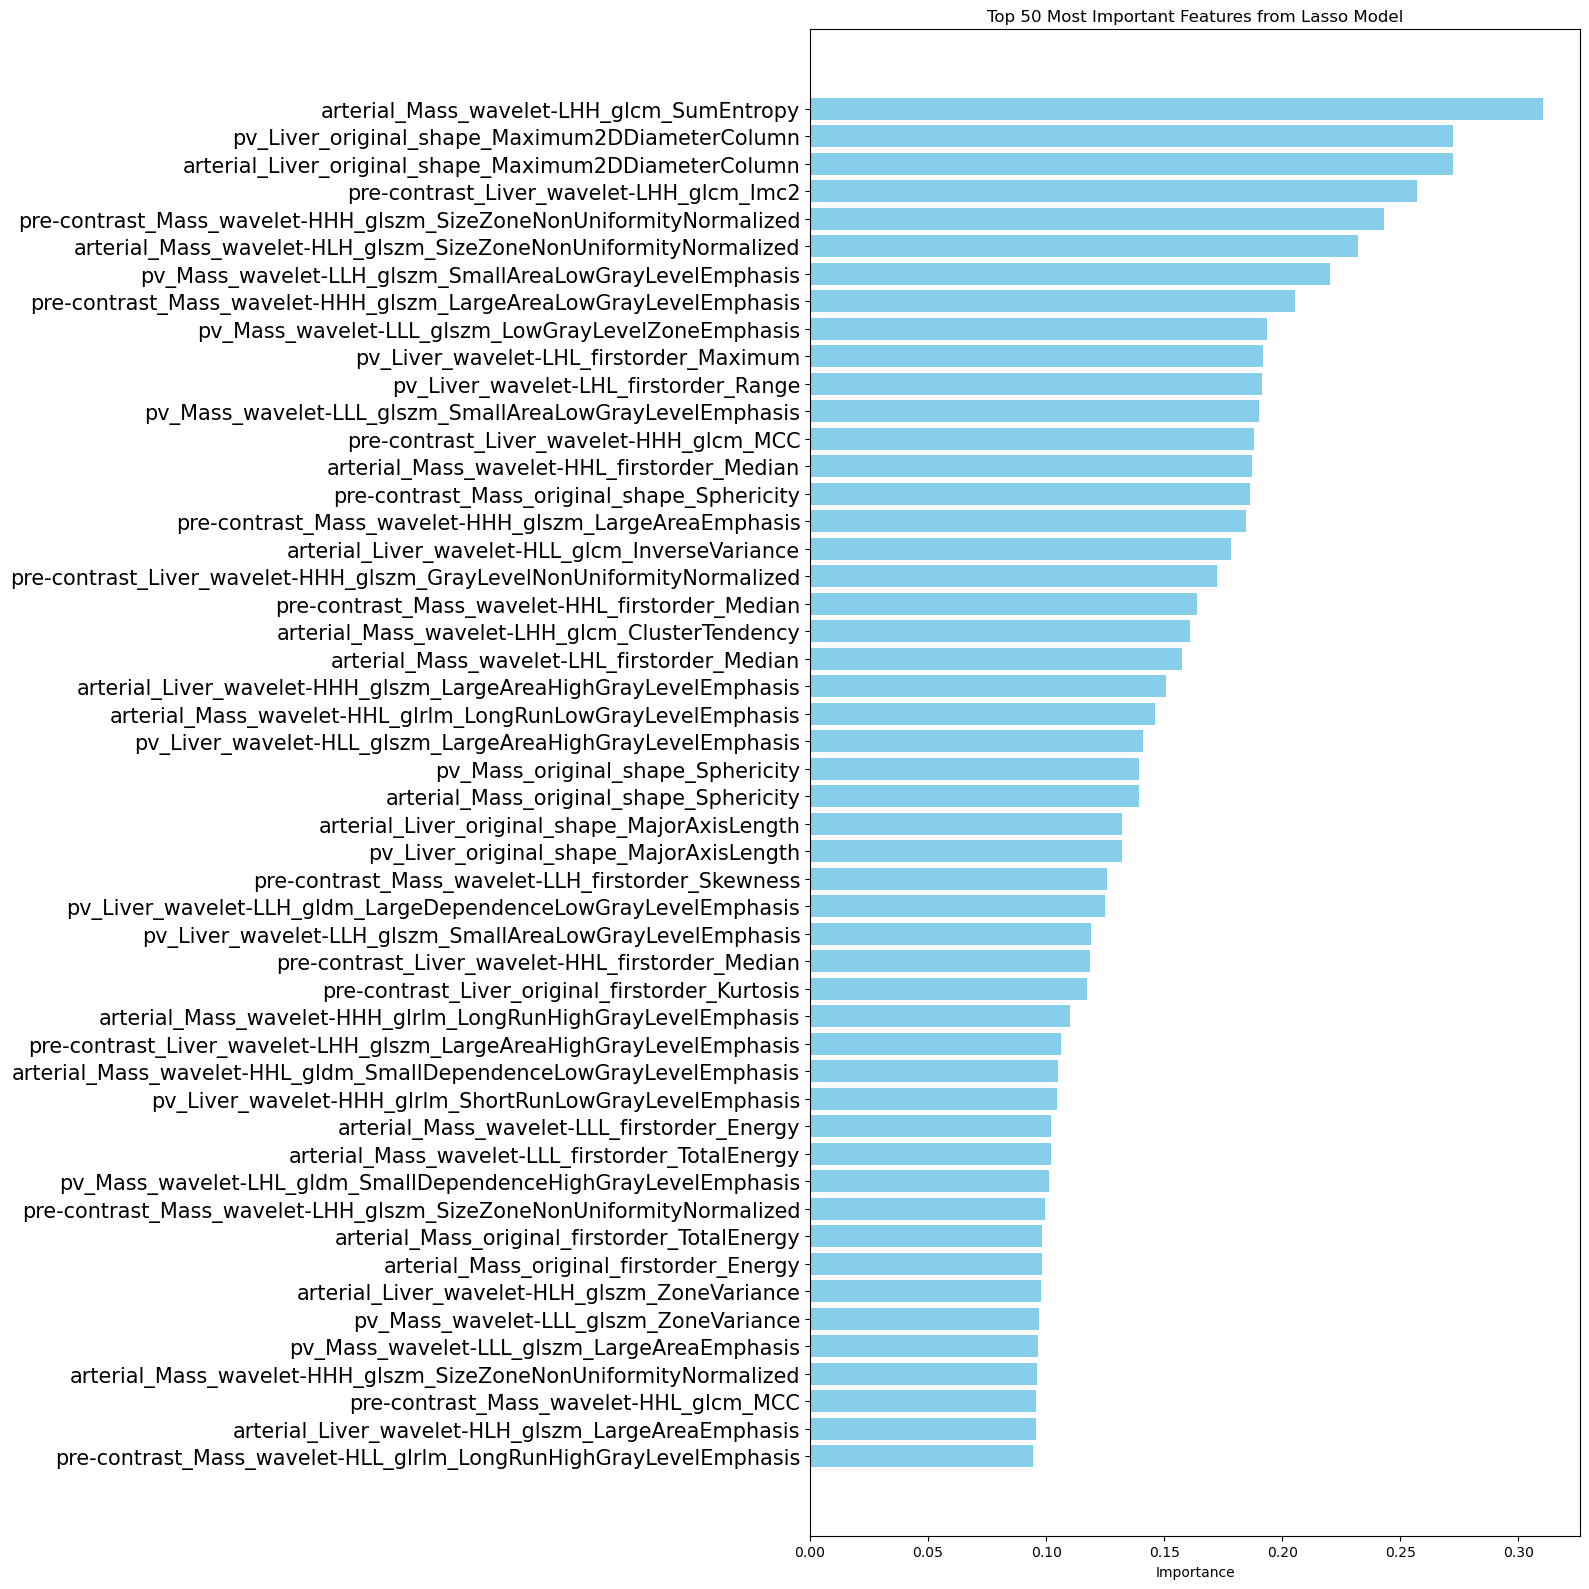

In [377]:
import matplotlib.pyplot as plt

# Get top 20 most important features
top_features = elasticnet_result["feature_importance"].sort_values("importance", ascending=False).head(50)

print(top_features)

# Create the plot
plt.figure(figsize=(16, 16))
plt.barh(top_features['feature'].to_list(), top_features['importance'], color='skyblue')
plt.yticks(fontsize=15)
plt.xlabel('Importance')
plt.title('Top 50 Most Important Features from Lasso Model')
plt.gca().invert_yaxis()  # Show highest importance at the top
plt.tight_layout()
plt.show()

In [378]:
feat_names = top_features['feature'].to_list()


top_features['phase'] = top_features['feature'].apply(lambda x: x.split("_")[0])
top_features['Region'] = top_features['feature'].apply(lambda x: x.split("_")[1])
top_features['is_wavelet'] = (top_features['feature'].apply(lambda x: "wavelet" in x.split("_")[2])).astype(int)

In [379]:
top_features['is_wavelet'].value_counts()

is_wavelet
1    40
0    10
Name: count, dtype: int64

Text(0.5, 0, 'Jumlah fitur per fase')

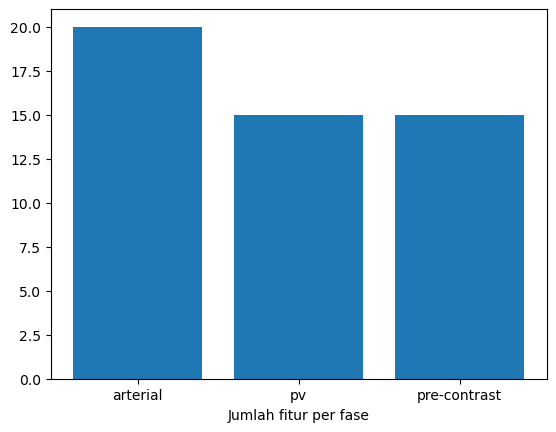

In [380]:
phase_tally = top_features['phase'].value_counts()

plt.bar(phase_tally.index, phase_tally.values)
plt.xlabel("Jumlah fitur per fase")

<BarContainer object of 2 artists>

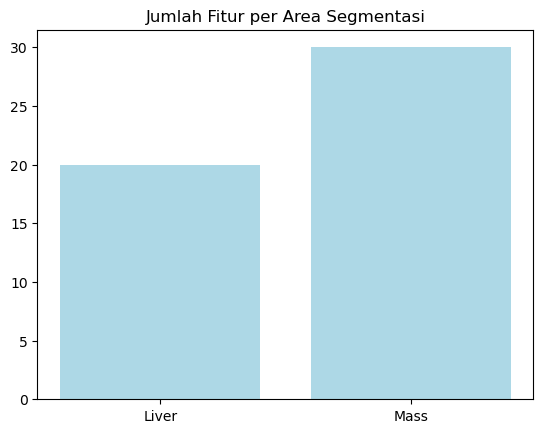

In [390]:
phase_pvt = top_features.pivot_table(index='feature', columns='Region', values='importance', aggfunc='count')

liver_counts = phase_pvt["Liver"].value_counts().values[0]
liver_counts 

phases = ['Liver', 'Mass']
counts = [liver_counts , 50 - liver_counts]
plt.title("Jumlah Fitur per Area Segmentasi")
plt.bar(
    phases,
    counts,
    color='lightblue',
    label='Train'
)

<Axes: >

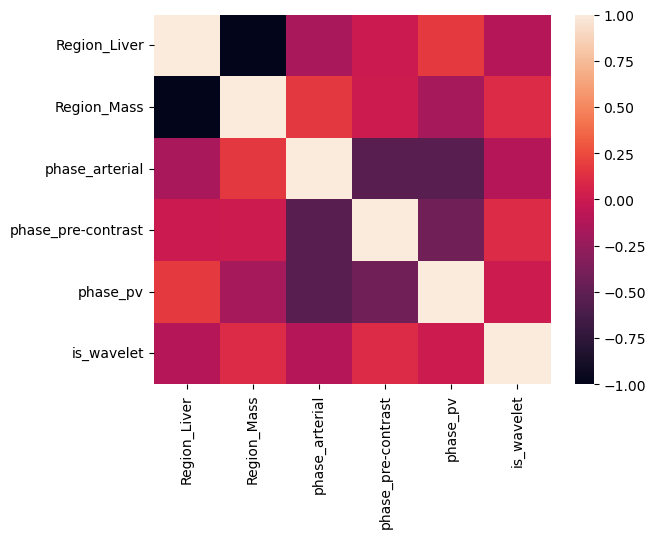

In [382]:
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

ohe = OneHotEncoder(sparse_output=False)

top_feats_encoded = ohe.fit_transform(top_features[['Region', 'phase']])

feature_names = ohe.get_feature_names_out(input_features=['Region', 'phase'])
# Create DataFrame with proper column names
encoded_df = pd.DataFrame(top_feats_encoded, columns=feature_names, index=top_features.index)
encoded_df = pd.concat([encoded_df, top_features['is_wavelet']], axis=1)
sns.heatmap(encoded_df.corr())



In [383]:
from scipy.stats import chi2_contingency

for region in top_features["Region"].unique():
    table = pd.crosstab(
        encoded_df[f"Region_{region}"],
        encoded_df[["phase_arterial", "phase_pre-contrast", "phase_pv"]].idxmax(axis=1)
    )

    chi2, p, dof, expected = chi2_contingency(table)

    print(f"p value of association between region {region} and phases : {p} ")


p value of association between region Mass and phases : 0.37824156666660563 
p value of association between region Liver and phases : 0.37824156666660563 


In [391]:
from sklearn.metrics import classification_report


##ORIGINAL 
# features = ['arterial_Mass_wavelet-LHH_glcm_SumEntropy',
#        'pre-contrast_Liver_wavelet-LHH_glcm_Imc2',
#        'pv_Liver_original_shape_Maximum2DDiameterColumn',
#        'arterial_Liver_original_shape_Maximum2DDiameterColumn',
#        'pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis',
#        'pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis',
#        'pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized',
#        'arterial_Mass_wavelet-HHL_firstorder_Median',
#        'pv_Liver_wavelet-LHL_firstorder_Maximum',
#        'pre-contrast_Mass_original_shape_Sphericity',
#        'chemo_Cisplatin_doxorubicin_Mitomycin-C',
#        'chemo_doxorubicin_LC_beads']



# features = ['arterial_Mass_wavelet-HHL_gldm_SmallDependenceLowGrayLevelEmphasis',
#        'pre-contrast_Mass_wavelet-HHL_firstorder_Median',
#        'pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized',
#        'pre-contrast_Mass_wavelet-LHH_ngtdm_Contrast',
#        'pv_Liver_wavelet-HLL_glszm_SizeZoneNonUniformityNormalized',
#        'pre-contrast_Liver_wavelet-HHL_glszm_GrayLevelVariance',
#        'pre-contrast_Mass_wavelet-LLH_firstorder_Kurtosis',
#        'pv_Mass_wavelet-HHH_gldm_SmallDependenceLowGrayLevelEmphasis',
#        'arterial_Mass_wavelet-LLL_glszm_ZonePercentage',
#        'arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized',
#        'pre-contrast_Mass_wavelet-HHH_ngtdm_Busyness',
#        'pre-contrast_Mass_wavelet-LLH_glcm_Idmn',
#        'pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis',
#        'arterial_Mass_wavelet-LLH_firstorder_Median',
#        'arterial_Mass_wavelet-LHL_firstorder_Median',
#        'chemo_Cisplatin_doxorubicin_Mitomycin-C',
#        'chemo_doxorubicin_LC_beads']

elasticnet_feats = ['arterial_Mass_wavelet-LHH_glcm_SumEntropy',
 'arterial_Liver_original_shape_Maximum2DDiameterColumn',
 'pv_Liver_original_shape_Maximum2DDiameterColumn',
 'pre-contrast_Liver_wavelet-LHH_glcm_Imc2',
 'pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized',
 'arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized',
 'pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis',
 'pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis',
 'pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis',
 'pv_Liver_wavelet-LHL_firstorder_Maximum',
 'pv_Liver_wavelet-LHL_firstorder_Range',
 'pv_Mass_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis',
 'pre-contrast_Liver_wavelet-HHH_glcm_MCC',
 'arterial_Mass_wavelet-HHL_firstorder_Median',
 'pre-contrast_Mass_original_shape_Sphericity',
 'pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaEmphasis',
 'arterial_Liver_wavelet-HLL_glcm_InverseVariance',
 'pre-contrast_Liver_wavelet-HHH_glszm_GrayLevelNonUniformityNormalized',
 'pre-contrast_Mass_wavelet-HHL_firstorder_Median',
 'arterial_Mass_wavelet-LHH_glcm_ClusterTendency',
 'arterial_Mass_wavelet-LHL_firstorder_Median',
 'arterial_Liver_wavelet-HHH_glszm_LargeAreaHighGrayLevelEmphasis',
 'arterial_Mass_wavelet-HHL_glrlm_LongRunLowGrayLevelEmphasis',
 'pv_Liver_wavelet-HLL_glszm_LargeAreaHighGrayLevelEmphasis',
 'arterial_Mass_original_shape_Sphericity',
 'pv_Mass_original_shape_Sphericity',
 'pv_Liver_original_shape_MajorAxisLength',
 'arterial_Liver_original_shape_MajorAxisLength',
 'pre-contrast_Mass_wavelet-LLH_firstorder_Skewness',
 'pv_Liver_wavelet-LLH_gldm_LargeDependenceLowGrayLevelEmphasis',
 'pv_Liver_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis',
 'pre-contrast_Liver_wavelet-HHL_firstorder_Median',
 'pre-contrast_Liver_original_firstorder_Kurtosis',
 'arterial_Mass_wavelet-HHH_glrlm_LongRunHighGrayLevelEmphasis',
 'pre-contrast_Liver_wavelet-LHH_glszm_LargeAreaHighGrayLevelEmphasis',
 'arterial_Mass_wavelet-HHL_gldm_SmallDependenceLowGrayLevelEmphasis',
 'pv_Liver_wavelet-HHH_glrlm_ShortRunLowGrayLevelEmphasis',
 'arterial_Mass_wavelet-LLL_firstorder_TotalEnergy',
 'arterial_Mass_wavelet-LLL_firstorder_Energy',
 'pv_Mass_wavelet-LHL_gldm_SmallDependenceHighGrayLevelEmphasis',
 'pre-contrast_Mass_wavelet-LHH_glszm_SizeZoneNonUniformityNormalized',
 'arterial_Mass_original_firstorder_TotalEnergy',
 'arterial_Mass_original_firstorder_Energy',
 'arterial_Liver_wavelet-HLH_glszm_ZoneVariance',
 'pv_Mass_wavelet-LLL_glszm_ZoneVariance',
 'pv_Mass_wavelet-LLL_glszm_LargeAreaEmphasis',
 'arterial_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized',
 'pre-contrast_Mass_wavelet-HHL_glcm_MCC',
 'arterial_Liver_wavelet-HLH_glszm_LargeAreaEmphasis',
 'pre-contrast_Mass_wavelet-HLL_glrlm_LongRunHighGrayLevelEmphasis']


features = elasticnet_feats[:30]

# features = features = [
#     "arterial_Mass_wavelet-LHH_glcm_SumEntropy",
#     "pre-contrast_Liver_wavelet-LHH_glcm_Imc2",
#     "arterial_Liver_original_shape_Maximum2DDiameterColumn",
#     "pv_Liver_original_shape_Maximum2DDiameterColumn",
#     "pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis",
#     "pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis",
#     "pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized",
#     "arterial_Mass_wavelet-HHL_firstorder_Median",
#     "pv_Liver_wavelet-LHL_firstorder_Maximum",
#     "pre-contrast_Mass_original_shape_Sphericity",
#     "arterial_Liver_wavelet-HLL_glcm_InverseVariance",
#     "pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis",
#     "arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized",
#     "pre-contrast_Liver_wavelet-HHH_glcm_MCC",
#     "pv_Liver_wavelet-LHL_firstorder_Range",
#     "pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaEmphasis",
#     "arterial_Mass_wavelet-LHL_firstorder_Median",
#     "pre-contrast_Liver_wavelet-HHH_glszm_GrayLevelNonUniformityNormalized",
#     "pv_Liver_wavelet-HLL_glszm_LargeAreaHighGrayLevelEmphasis",
#     "pv_Mass_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis",
#     "pre-contrast_Mass_wavelet-LLH_firstorder_Skewness"
# ]

# Prepare the data


In [369]:
features

['arterial_Mass_wavelet-LHH_glcm_SumEntropy',
 'arterial_Liver_original_shape_Maximum2DDiameterColumn',
 'pv_Liver_original_shape_Maximum2DDiameterColumn',
 'pre-contrast_Liver_wavelet-LHH_glcm_Imc2',
 'pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized',
 'arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized',
 'pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis',
 'pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis',
 'pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis',
 'pv_Liver_wavelet-LHL_firstorder_Maximum',
 'pv_Liver_wavelet-LHL_firstorder_Range',
 'pv_Mass_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis',
 'pre-contrast_Liver_wavelet-HHH_glcm_MCC',
 'arterial_Mass_wavelet-HHL_firstorder_Median',
 'pre-contrast_Mass_original_shape_Sphericity',
 'pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaEmphasis',
 'arterial_Liver_wavelet-HLL_glcm_InverseVariance',
 'pre-contrast_Liver_wavelet-HHH_glszm_GrayLevelNonUniformityNormalized',
 'pr

## Graphs for Reporting


In [370]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score , roc_curve, roc_auc_score,
    average_precision_score, accuracy_score, precision_recall_curve,
    RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.calibration import  CalibratedClassifierCV
from imblearn.over_sampling import ADASYN, SMOTE

import seaborn as sns

from sklearn.model_selection import TunedThresholdClassifierCV
# --- Prepare data and model ---
df = radiomics_df_final.copy()
df = pd.merge(df, clin_df[[*chemo_columns, "TCIA_ID"]], on="TCIA_ID", validate="one_to_one")

X_tr, X_ts, y_tr, y_ts = train_test_split_patients(
    df, identifier="TCIA_ID", endpoint="responder", test_ratio=train_test_ratio, random_state=train_test_seed)

pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="mean")),
    ("scale", StandardScaler())
])

x_cols = X_tr.columns
X_tr = pd.DataFrame(pipeline.fit_transform(X_tr), columns=x_cols)
X_ts = pd.DataFrame(pipeline.transform(X_ts), columns=x_cols)

used_features = features[:33] + chemo_columns  # Creates a new list

# adas = SMOTE(random_state=42)
# X_tr, y_tr = adas.fit_resample(X_tr[used_features], y_tr)

current_model_grid = stacking_grid #

current_model_grid.fit(X_tr[used_features], y_tr)
good_estimator_params = current_model_grid.best_estimator_

try:
    threshold_tuner = TunedThresholdClassifierCV(good_estimator_params, cv="prefit", refit=False, random_state=42, response_method="predict_proba", scoring = "recall")
    threshold_tuner.fit(X_tr[used_features], y_tr)

    optimal_threshold = 0.6

    print(f"optimal decision function threshold: {optimal_threshold}")

    # --- Predict probabilities ---
    y_prob_ts = good_estimator_params.predict_proba(X_ts[used_features])[:, 1]

    # --- ROC Curve and AUC ---
    fpr, tpr, roc_thresholds = roc_curve(y_ts, y_prob_ts)
    roc_auc = roc_auc_score(y_ts, y_prob_ts)
    y_pred = (y_prob_ts > optimal_threshold).astype(int)
    average_precision = average_precision_score(y_ts, y_prob_ts)

except AttributeError:
    # threshold_tuner = TunedThresholdClassifierCV(good_estimator_params, cv="prefit", refit=False, random_state=42, response_method="decision_function", scoring = "precision")
    # threshold_tuner.fit(X_tr[used_features], y_tr)

    optimal_threshold = 0.5

    print(f"optimal decision function threshold: {optimal_threshold}")

    # --- Predict probabilities ---
    y_prob_ts = good_estimator_params.decision_function(X_ts[used_features])

    # --- ROC Curve and AUC ---
    fpr, tpr, roc_thresholds = roc_curve(y_ts, y_prob_ts)


    roc_auc = roc_auc_score(y_ts, y_prob_ts)
    y_pred = (y_prob_ts > optimal_threshold).astype(int)
    average_precision = average_precision_score(y_ts, y_prob_ts)

plt.figure(figsize=(10, 8))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Precision-Recall Curve and optimal F1 threshold ---
precision, recall, thresholds = precision_recall_curve(y_ts, y_prob_ts)
fscore = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1])


plt.figure(figsize=(10, 8))
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision)
pr_display.plot()
plt.scatter(recall, precision, marker='o', color='red')
plt.title('Precision-Recall Curve', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# --- Metrics ---
tn, fp, fn, tp = confusion_matrix(y_ts, y_pred).ravel()
specificity = tn / (tn + fp)

# Calculate metrics
precision = precision_score(y_ts, y_pred)
recall = recall_score(y_ts, y_pred)
f1 = f1_score(y_ts, y_pred)

sns.heatmap(confusion_matrix(y_ts, y_pred), annot=True, fmt='d')

# Print metrics
print("="*50)
print(f"{'Model Performance Metrics':^50}")
print("="*50)
print(f"{'Accuracy:':<25} {accuracy_score(y_ts, y_pred):.4f}")
print(f"{'Precision:':<25} {precision:.4f}")
print(f"{'Recall:':<25} {recall:.4f}")
print(f"{'F1 Score:':<25} {f1:.4f}")
print(f"{'Specificity:':<25} {specificity:.4f}")
print(f"{'ROC AUC:':<25} {roc_auc:.4f}")
print(f"{'Average Precision:':<25} {average_precision:.4f}")
print("="*50)
 

Train Set Patient Count: 52
Test Set Patient Count: 23
Train Set Endpoint Distribution:
responder
0.0    0.673077
1.0    0.326923
Name: proportion, dtype: float64
Test Set Endpoint Distribution:
responder
0.0    0.695652
1.0    0.304348
Name: proportion, dtype: float64
Fitting 15 folds for each of 20 candidates, totalling 300 fits


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import os

from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_curve, roc_auc_score,
    average_precision_score, accuracy_score, precision_recall_curve,
    RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix
)

def update_model_results(model_name, num_features, y_true, y_pred, y_prob, output_file="model_optimum_features.xlsx"):
    """
    Update or append model results to an Excel file.
    
    Args:
        model_name (str): Name of the model
        num_features (int): Number of features used
        y_true: True labels
        y_pred: Predicted labels
        y_prob: Predicted probabilities (for ROC AUC and Average Precision)
        output_file (str): Path to the output Excel file
    """
    # Calculate metrics
    metrics = {
        'name': model_name,
        'number_of_features': num_features,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred),
        'specificity': (confusion_matrix(y_true, y_pred)[0, 0] / 
                       (confusion_matrix(y_true, y_pred)[0, 0] + confusion_matrix(y_true, y_pred)[0, 1])),
        'roc_auc': roc_auc_score(y_true, y_prob),
        'average_precision': average_precision_score(y_true, y_prob)
    }
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame([metrics])
    
    # Check if file exists
    if os.path.exists(output_file):
        existing_df = pd.read_excel(output_file)
        
        # If model name exists, update the row
        metrics_df = pd.concat([existing_df, metrics_df], ignore_index=True)

    
    # Save to Excel
    metrics_df.to_excel(output_file, index=False)

In [ ]:
len(np.arange(3, 50, 6))


8

Train Set Patient Count: 52
Test Set Patient Count: 23
Train Set Endpoint Distribution:
responder
0.0    0.673077
1.0    0.326923
Name: proportion, dtype: float64
Test Set Endpoint Distribution:
responder
0.0    0.695652
1.0    0.304348
Name: proportion, dtype: float64
['arterial_Mass_wavelet-LHH_glcm_SumEntropy', 'arterial_Liver_original_shape_Maximum2DDiameterColumn', 'pv_Liver_original_shape_Maximum2DDiameterColumn', 'chemo_Cisplatin_doxorubicin_Mitomycin-C', 'chemo_doxorubicin_LC_beads']
Fitting 15 folds for each of 20 candidates, totalling 300 fits


<Figure size 1000x800 with 0 Axes>

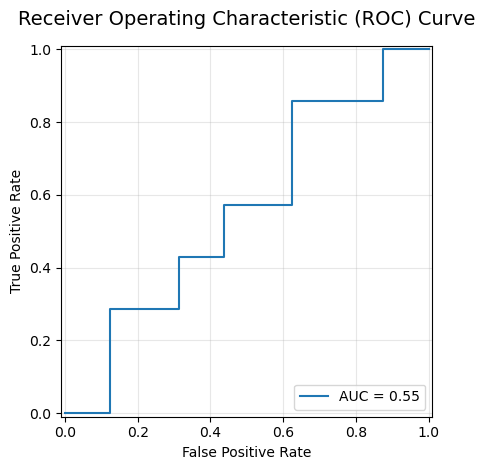

<Figure size 1000x800 with 0 Axes>

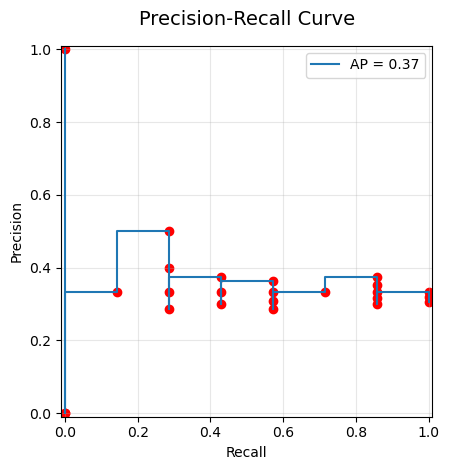

Model Performance Metrics of 3 features:
Accuracy:                 0.6087
Precision:                0.3333
Recall:                   0.2857
F1 Score:                 0.3077
Specificity:              0.7500
ROC AUC:                  0.5536
Average Precision:        0.3734
['arterial_Mass_wavelet-LHH_glcm_SumEntropy', 'arterial_Liver_original_shape_Maximum2DDiameterColumn', 'pv_Liver_original_shape_Maximum2DDiameterColumn', 'pre-contrast_Liver_wavelet-LHH_glcm_Imc2', 'pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized', 'arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', 'chemo_Cisplatin_doxorubicin_Mitomycin-C', 'chemo_doxorubicin_LC_beads']
Fitting 15 folds for each of 20 candidates, totalling 300 fits


<Figure size 1000x800 with 0 Axes>

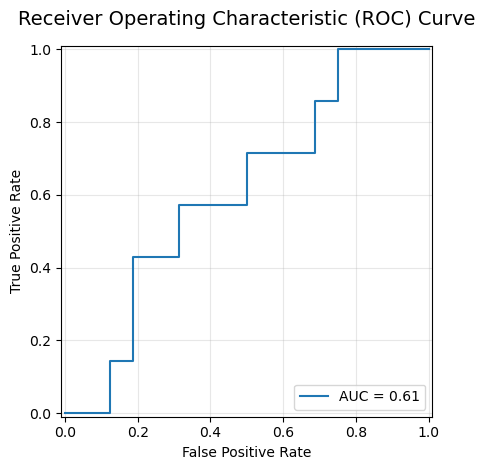

<Figure size 1000x800 with 0 Axes>

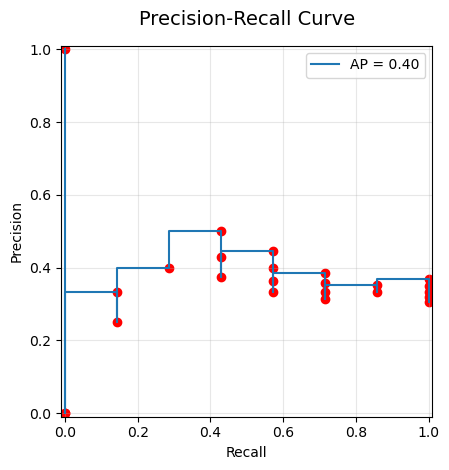

Model Performance Metrics of 6 features:
Accuracy:                 0.6087
Precision:                0.3750
Recall:                   0.4286
F1 Score:                 0.4000
Specificity:              0.6875
ROC AUC:                  0.6071
Average Precision:        0.3977
['arterial_Mass_wavelet-LHH_glcm_SumEntropy', 'arterial_Liver_original_shape_Maximum2DDiameterColumn', 'pv_Liver_original_shape_Maximum2DDiameterColumn', 'pre-contrast_Liver_wavelet-LHH_glcm_Imc2', 'pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized', 'arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', 'pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis', 'pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis', 'chemo_Cisplatin_doxorubicin_Mitomycin-C', 'chemo_doxorubicin_LC_beads']
Fitting 15 folds for each of 20 candidates, totalling 300 fits


<Figure size 1000x800 with 0 Axes>

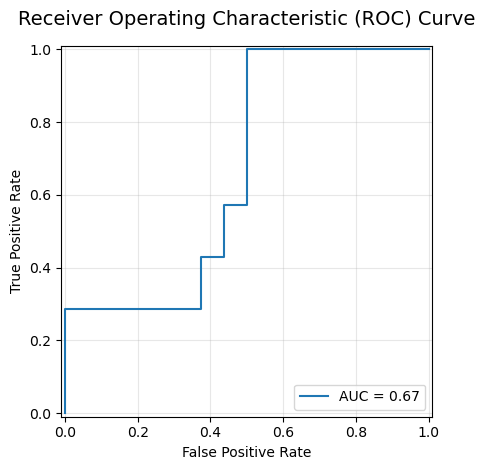

<Figure size 1000x800 with 0 Axes>

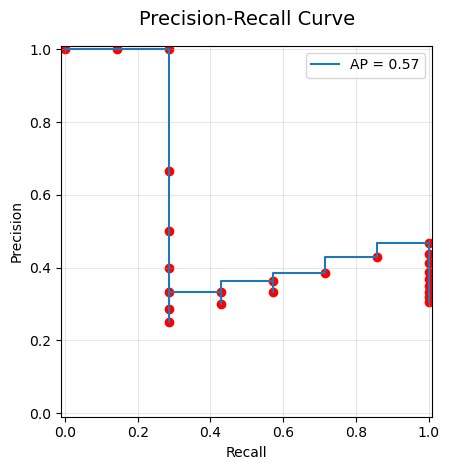

Model Performance Metrics of 9 features:
Accuracy:                 0.6522
Precision:                0.4000
Recall:                   0.2857
F1 Score:                 0.3333
Specificity:              0.8125
ROC AUC:                  0.6696
Average Precision:        0.5681
['arterial_Mass_wavelet-LHH_glcm_SumEntropy', 'arterial_Liver_original_shape_Maximum2DDiameterColumn', 'pv_Liver_original_shape_Maximum2DDiameterColumn', 'pre-contrast_Liver_wavelet-LHH_glcm_Imc2', 'pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized', 'arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', 'pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis', 'pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis', 'pv_Liver_wavelet-LHL_firstorder_Maximum', 'pv_Liver_wavelet-LHL_firstorder_Range', 'pv_Mass_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis', 'chemo_Cisplatin_doxorubicin_Mitomycin-C', 'chemo_doxorubicin_LC_be

<Figure size 1000x800 with 0 Axes>

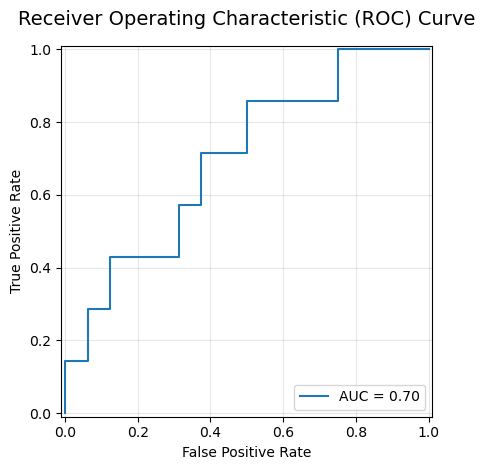

<Figure size 1000x800 with 0 Axes>

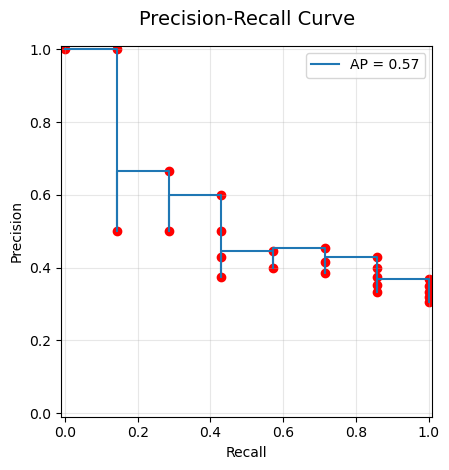

Model Performance Metrics of 12 features:
Accuracy:                 0.7391
Precision:                0.6000
Recall:                   0.4286
F1 Score:                 0.5000
Specificity:              0.8750
ROC AUC:                  0.6964
Average Precision:        0.5661
['arterial_Mass_wavelet-LHH_glcm_SumEntropy', 'arterial_Liver_original_shape_Maximum2DDiameterColumn', 'pv_Liver_original_shape_Maximum2DDiameterColumn', 'pre-contrast_Liver_wavelet-LHH_glcm_Imc2', 'pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized', 'arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', 'pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis', 'pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis', 'pv_Liver_wavelet-LHL_firstorder_Maximum', 'pv_Liver_wavelet-LHL_firstorder_Range', 'pv_Mass_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Liver_wavelet-HHH_glcm_MCC', 'arterial_Mass_wavelet-

<Figure size 1000x800 with 0 Axes>

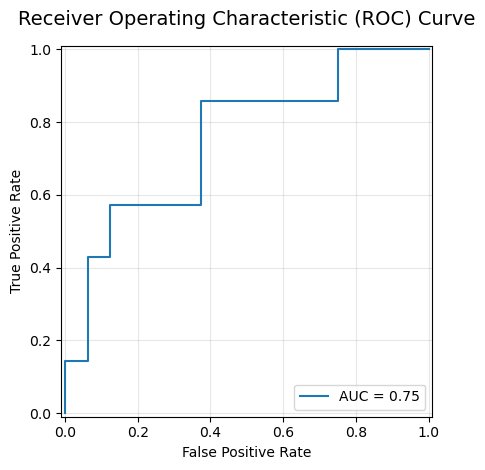

<Figure size 1000x800 with 0 Axes>

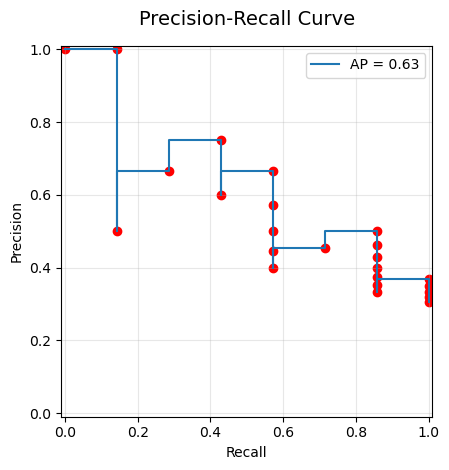

Model Performance Metrics of 15 features:
Accuracy:                 0.7826
Precision:                0.7500
Recall:                   0.4286
F1 Score:                 0.5455
Specificity:              0.9375
ROC AUC:                  0.7500
Average Precision:        0.6295
['arterial_Mass_wavelet-LHH_glcm_SumEntropy', 'arterial_Liver_original_shape_Maximum2DDiameterColumn', 'pv_Liver_original_shape_Maximum2DDiameterColumn', 'pre-contrast_Liver_wavelet-LHH_glcm_Imc2', 'pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized', 'arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', 'pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis', 'pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis', 'pv_Liver_wavelet-LHL_firstorder_Maximum', 'pv_Liver_wavelet-LHL_firstorder_Range', 'pv_Mass_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Liver_wavelet-HHH_glcm_MCC', 'arterial_Mass_wavelet-

<Figure size 1000x800 with 0 Axes>

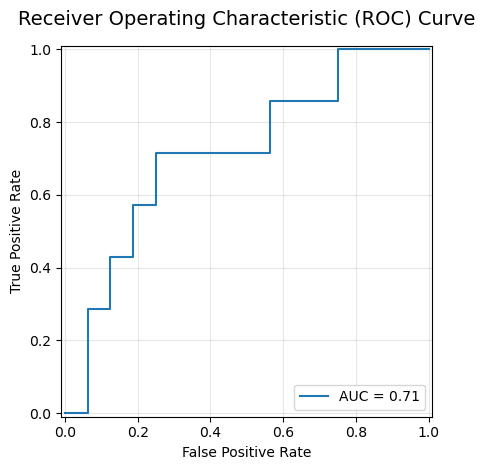

<Figure size 1000x800 with 0 Axes>

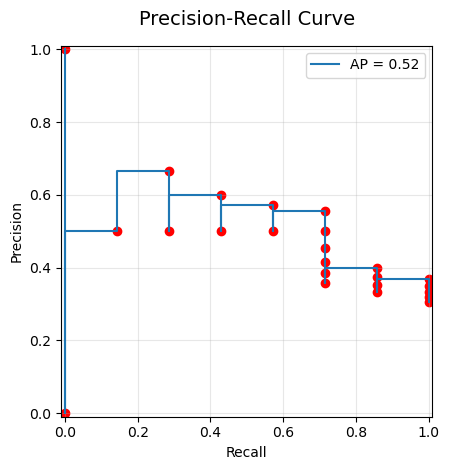

Model Performance Metrics of 18 features:
Accuracy:                 0.7391
Precision:                0.5714
Recall:                   0.5714
F1 Score:                 0.5714
Specificity:              0.8125
ROC AUC:                  0.7143
Average Precision:        0.5232
['arterial_Mass_wavelet-LHH_glcm_SumEntropy', 'arterial_Liver_original_shape_Maximum2DDiameterColumn', 'pv_Liver_original_shape_Maximum2DDiameterColumn', 'pre-contrast_Liver_wavelet-LHH_glcm_Imc2', 'pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized', 'arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', 'pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis', 'pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis', 'pv_Liver_wavelet-LHL_firstorder_Maximum', 'pv_Liver_wavelet-LHL_firstorder_Range', 'pv_Mass_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Liver_wavelet-HHH_glcm_MCC', 'arterial_Mass_wavelet-

<Figure size 1000x800 with 0 Axes>

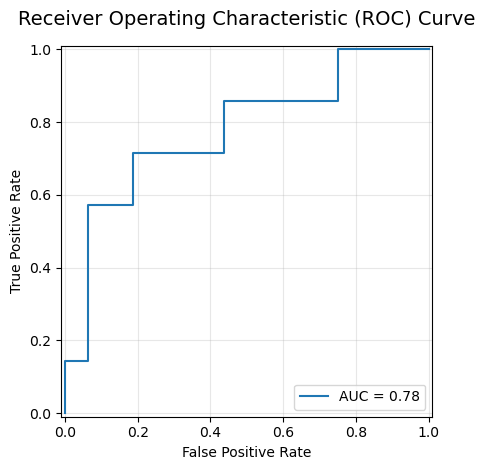

<Figure size 1000x800 with 0 Axes>

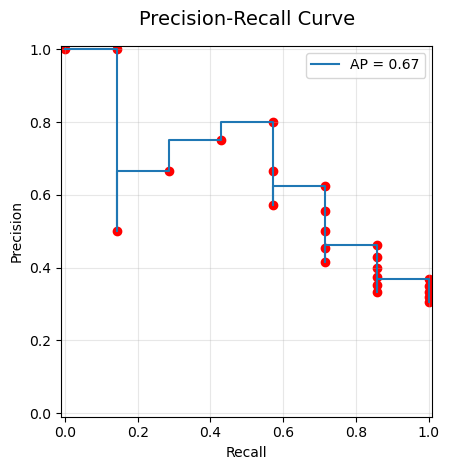

Model Performance Metrics of 21 features:
Accuracy:                 0.7391
Precision:                0.5714
Recall:                   0.5714
F1 Score:                 0.5714
Specificity:              0.8125
ROC AUC:                  0.7768
Average Precision:        0.6674
['arterial_Mass_wavelet-LHH_glcm_SumEntropy', 'arterial_Liver_original_shape_Maximum2DDiameterColumn', 'pv_Liver_original_shape_Maximum2DDiameterColumn', 'pre-contrast_Liver_wavelet-LHH_glcm_Imc2', 'pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized', 'arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', 'pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis', 'pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis', 'pv_Liver_wavelet-LHL_firstorder_Maximum', 'pv_Liver_wavelet-LHL_firstorder_Range', 'pv_Mass_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Liver_wavelet-HHH_glcm_MCC', 'arterial_Mass_wavelet-

<Figure size 1000x800 with 0 Axes>

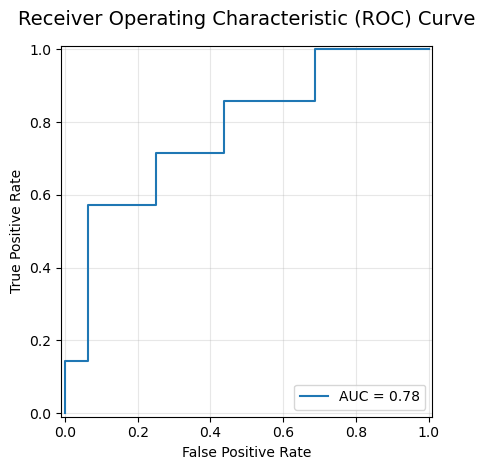

<Figure size 1000x800 with 0 Axes>

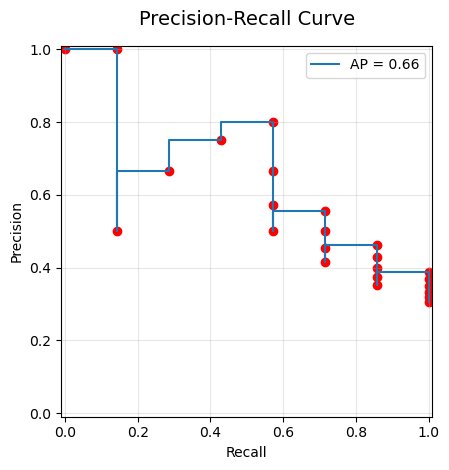

Model Performance Metrics of 24 features:
Accuracy:                 0.7826
Precision:                0.6667
Recall:                   0.5714
F1 Score:                 0.6154
Specificity:              0.8750
ROC AUC:                  0.7768
Average Precision:        0.6604
['arterial_Mass_wavelet-LHH_glcm_SumEntropy', 'arterial_Liver_original_shape_Maximum2DDiameterColumn', 'pv_Liver_original_shape_Maximum2DDiameterColumn', 'pre-contrast_Liver_wavelet-LHH_glcm_Imc2', 'pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized', 'arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', 'pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis', 'pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis', 'pv_Liver_wavelet-LHL_firstorder_Maximum', 'pv_Liver_wavelet-LHL_firstorder_Range', 'pv_Mass_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Liver_wavelet-HHH_glcm_MCC', 'arterial_Mass_wavelet-

<Figure size 1000x800 with 0 Axes>

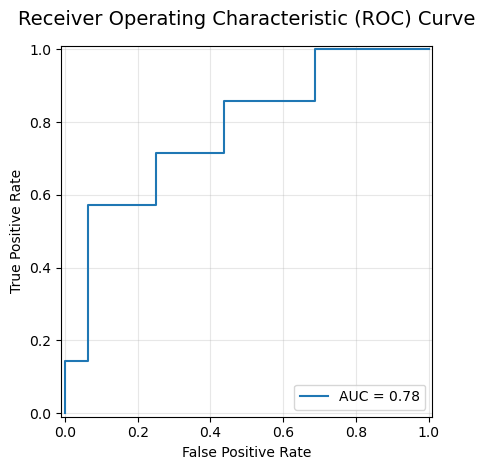

<Figure size 1000x800 with 0 Axes>

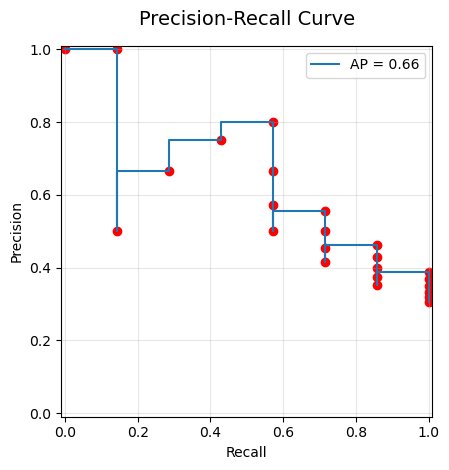

Model Performance Metrics of 27 features:
Accuracy:                 0.6957
Precision:                0.5000
Recall:                   0.5714
F1 Score:                 0.5333
Specificity:              0.7500
ROC AUC:                  0.7768
Average Precision:        0.6604
['arterial_Mass_wavelet-LHH_glcm_SumEntropy', 'arterial_Liver_original_shape_Maximum2DDiameterColumn', 'pv_Liver_original_shape_Maximum2DDiameterColumn', 'pre-contrast_Liver_wavelet-LHH_glcm_Imc2', 'pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized', 'arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', 'pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis', 'pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis', 'pv_Liver_wavelet-LHL_firstorder_Maximum', 'pv_Liver_wavelet-LHL_firstorder_Range', 'pv_Mass_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Liver_wavelet-HHH_glcm_MCC', 'arterial_Mass_wavelet-

<Figure size 1000x800 with 0 Axes>

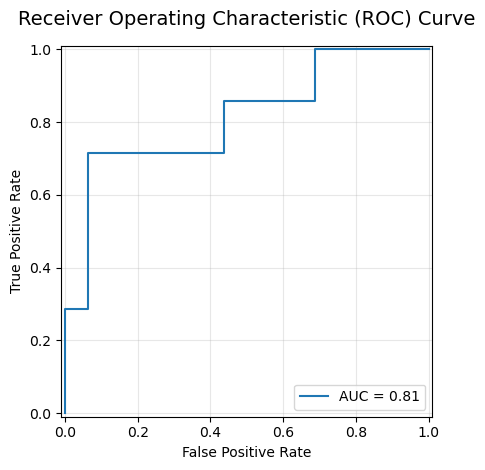

<Figure size 1000x800 with 0 Axes>

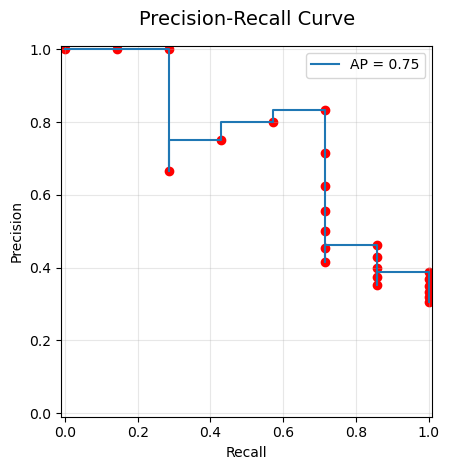

Model Performance Metrics of 30 features:
Accuracy:                 0.8261
Precision:                0.8000
Recall:                   0.5714
F1 Score:                 0.6667
Specificity:              0.9375
ROC AUC:                  0.8125
Average Precision:        0.7477
['arterial_Mass_wavelet-LHH_glcm_SumEntropy', 'arterial_Liver_original_shape_Maximum2DDiameterColumn', 'pv_Liver_original_shape_Maximum2DDiameterColumn', 'pre-contrast_Liver_wavelet-LHH_glcm_Imc2', 'pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized', 'arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', 'pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis', 'pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis', 'pv_Liver_wavelet-LHL_firstorder_Maximum', 'pv_Liver_wavelet-LHL_firstorder_Range', 'pv_Mass_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Liver_wavelet-HHH_glcm_MCC', 'arterial_Mass_wavelet-

<Figure size 1000x800 with 0 Axes>

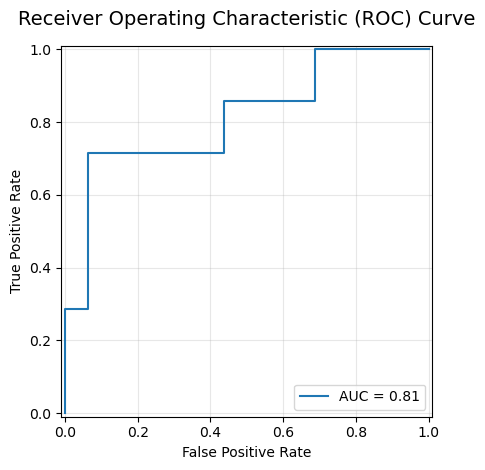

<Figure size 1000x800 with 0 Axes>

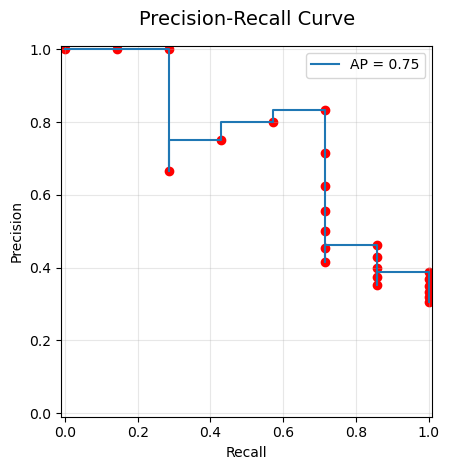

Model Performance Metrics of 33 features:
Accuracy:                 0.8261
Precision:                0.8000
Recall:                   0.5714
F1 Score:                 0.6667
Specificity:              0.9375
ROC AUC:                  0.8125
Average Precision:        0.7477
['arterial_Mass_wavelet-LHH_glcm_SumEntropy', 'arterial_Liver_original_shape_Maximum2DDiameterColumn', 'pv_Liver_original_shape_Maximum2DDiameterColumn', 'pre-contrast_Liver_wavelet-LHH_glcm_Imc2', 'pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized', 'arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', 'pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis', 'pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis', 'pv_Liver_wavelet-LHL_firstorder_Maximum', 'pv_Liver_wavelet-LHL_firstorder_Range', 'pv_Mass_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Liver_wavelet-HHH_glcm_MCC', 'arterial_Mass_wavelet-

<Figure size 1000x800 with 0 Axes>

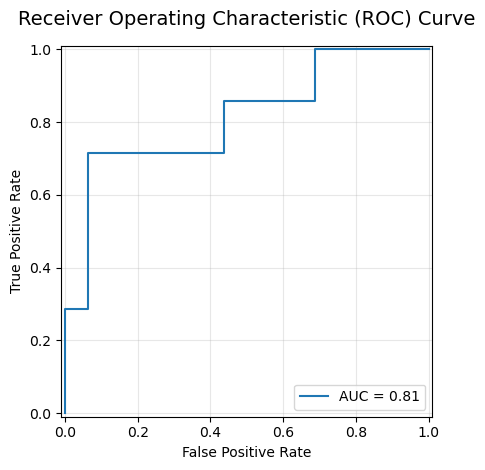

<Figure size 1000x800 with 0 Axes>

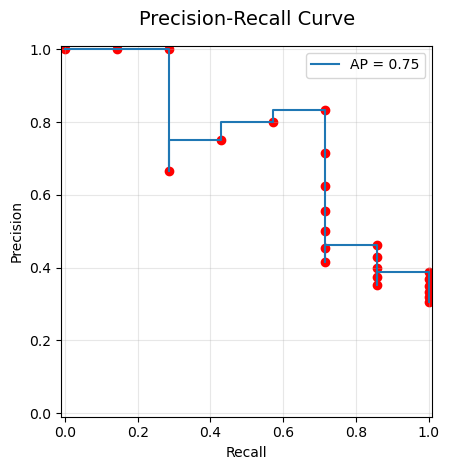

Model Performance Metrics of 36 features:
Accuracy:                 0.8261
Precision:                0.8000
Recall:                   0.5714
F1 Score:                 0.6667
Specificity:              0.9375
ROC AUC:                  0.8125
Average Precision:        0.7477
['arterial_Mass_wavelet-LHH_glcm_SumEntropy', 'arterial_Liver_original_shape_Maximum2DDiameterColumn', 'pv_Liver_original_shape_Maximum2DDiameterColumn', 'pre-contrast_Liver_wavelet-LHH_glcm_Imc2', 'pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized', 'arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', 'pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis', 'pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis', 'pv_Liver_wavelet-LHL_firstorder_Maximum', 'pv_Liver_wavelet-LHL_firstorder_Range', 'pv_Mass_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Liver_wavelet-HHH_glcm_MCC', 'arterial_Mass_wavelet-

<Figure size 1000x800 with 0 Axes>

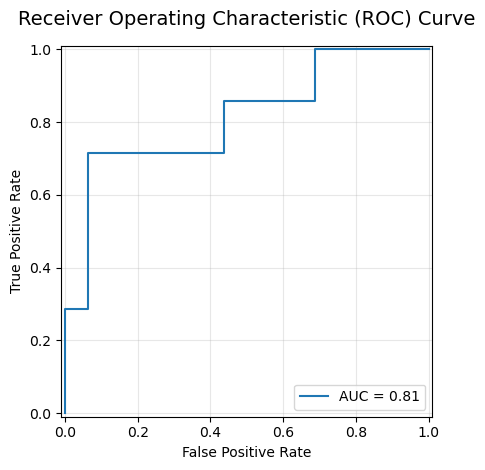

<Figure size 1000x800 with 0 Axes>

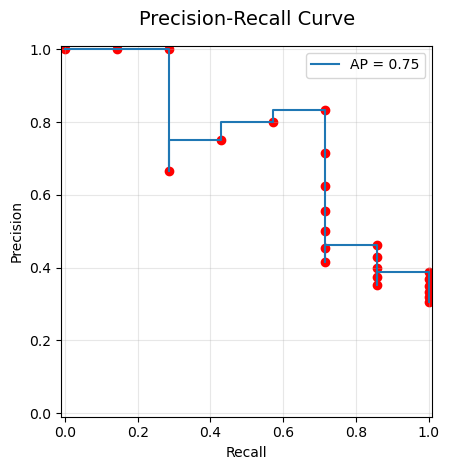

Model Performance Metrics of 39 features:
Accuracy:                 0.8261
Precision:                0.8000
Recall:                   0.5714
F1 Score:                 0.6667
Specificity:              0.9375
ROC AUC:                  0.8125
Average Precision:        0.7477
['arterial_Mass_wavelet-LHH_glcm_SumEntropy', 'arterial_Liver_original_shape_Maximum2DDiameterColumn', 'pv_Liver_original_shape_Maximum2DDiameterColumn', 'pre-contrast_Liver_wavelet-LHH_glcm_Imc2', 'pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized', 'arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', 'pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis', 'pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis', 'pv_Liver_wavelet-LHL_firstorder_Maximum', 'pv_Liver_wavelet-LHL_firstorder_Range', 'pv_Mass_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Liver_wavelet-HHH_glcm_MCC', 'arterial_Mass_wavelet-

<Figure size 1000x800 with 0 Axes>

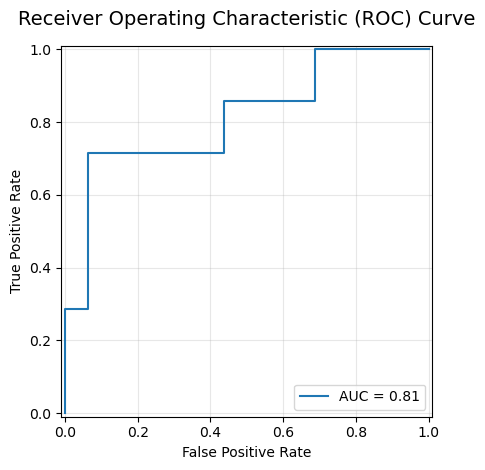

<Figure size 1000x800 with 0 Axes>

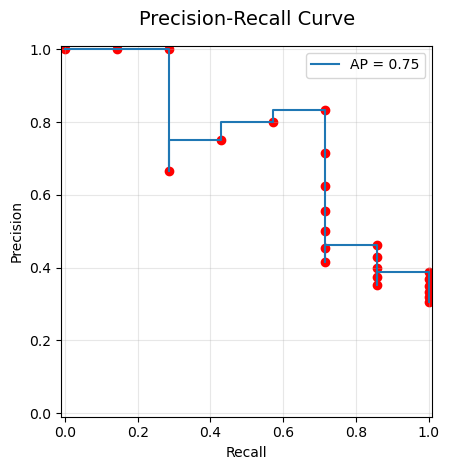

Model Performance Metrics of 42 features:
Accuracy:                 0.8261
Precision:                0.8000
Recall:                   0.5714
F1 Score:                 0.6667
Specificity:              0.9375
ROC AUC:                  0.8125
Average Precision:        0.7477
['arterial_Mass_wavelet-LHH_glcm_SumEntropy', 'arterial_Liver_original_shape_Maximum2DDiameterColumn', 'pv_Liver_original_shape_Maximum2DDiameterColumn', 'pre-contrast_Liver_wavelet-LHH_glcm_Imc2', 'pre-contrast_Mass_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized', 'arterial_Mass_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', 'pv_Mass_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Mass_wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis', 'pv_Mass_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis', 'pv_Liver_wavelet-LHL_firstorder_Maximum', 'pv_Liver_wavelet-LHL_firstorder_Range', 'pv_Mass_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis', 'pre-contrast_Liver_wavelet-HHH_glcm_MCC', 'arterial_Mass_wavelet-

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_curve, roc_auc_score,
    average_precision_score, accuracy_score, precision_recall_curve,
    RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.calibration import  CalibratedClassifierCV

# --- Prepare data and model ---
df = radiomics_df_final.copy()
df = pd.merge(df, clin_df[[*chemo_columns, "TCIA_ID"]], on="TCIA_ID", validate="one_to_one")

X_tr, X_ts, y_tr, y_ts = train_test_split_patients(
    df, identifier="TCIA_ID", endpoint="responder", test_ratio=train_test_ratio, random_state=train_test_seed
)

pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="mean")),
    ("scale", StandardScaler())
])

x_cols = X_tr.columns
X_tr = pd.DataFrame(pipeline.fit_transform(X_tr), columns=x_cols)
X_ts = pd.DataFrame(pipeline.transform(X_ts), columns=x_cols)

current_model_grid = stacking_grid


for feat_count in np.arange(3, 50, 3):
    # Fit the grid search on the training set
    pruned_features = features[:feat_count] + chemo_columns  # Creates a new list

    print(pruned_features)

    current_model_grid.fit(X_tr[pruned_features], y_tr)
    good_estimator_params = current_model_grid.best_estimator_

    # --- Predict probabilities ---
    try:
        y_prob_ts = good_estimator_params.predict_proba(X_ts[pruned_features])[:,1]

    except AttributeError:
        y_prob_ts = good_estimator_params.decision_function(X_ts[pruned_features])
              

    # --- ROC Curve and AUC ---
    fpr, tpr, roc_thresholds = roc_curve(y_ts, y_prob_ts)
    roc_auc = roc_auc_score(y_ts, y_prob_ts)

    plt.figure(figsize=(10, 8))
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_display.plot()
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, pad=15)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Precision-Recall Curve and optimal F1 threshold ---
    precision, recall, thresholds = precision_recall_curve(y_ts, y_prob_ts)
    fscore = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1])

    # ix = np.argmax(fscore)
    # optimal_threshold = thresholds[ix]

    # cal_svc = CalibratedClassifierCV(good_estimator_params, method='sigmoid', cv='prefit')
    # cal_svc.fit(X_tr[features], y_tr)
    # y_prob_ts = cal_svc.predict_proba(X_ts[features])[:, 1]  # now 0-1 probabilities

    # # --- Precision-Recall and F1 ---
    # precision, recall, thresholds = precision_recall_curve(y_ts, y_prob_ts)
    # fscore = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1])
    # ix = np.argmax(fscore)
    # optimal_threshold = thresholds[ix]

    y_pred = good_estimator_params.predict(X_ts[pruned_features])
    average_precision = average_precision_score(y_ts, y_prob_ts)

    plt.figure(figsize=(10, 8))
    pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision)
    pr_display.plot()
    plt.scatter(recall, precision, marker='o', color='red')
    plt.title('Precision-Recall Curve', fontsize=14, pad=15)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    # --- Metrics ---
    tn, fp, fn, tp = confusion_matrix(y_ts, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Calculate metrics
    precision = precision_score(y_ts, y_pred)
    recall = recall_score(y_ts, y_pred)
    f1 = f1_score(y_ts, y_pred)

    # Print metrics
    print("="*50)
    print(f"Model Performance Metrics of {feat_count} features:")
    print("="*50)
    print(f"{'Accuracy:':<25} {accuracy_score(y_ts, y_pred):.4f}")
    print(f"{'Precision:':<25} {precision:.4f}")
    print(f"{'Recall:':<25} {recall:.4f}")
    print(f"{'F1 Score:':<25} {f1:.4f}")
    print(f"{'Specificity:':<25} {specificity:.4f}")
    print(f"{'ROC AUC:':<25} {roc_auc:.4f}")
    print(f"{'Average Precision:':<25} {average_precision:.4f}")
    print("="*50)
    
    # After calculating all metrics, update the results file
    update_model_results(
        model_name=current_model_grid.best_estimator_.__class__.__name__,  # or whatever your model name is
        num_features=feat_count,
        y_true=y_ts,
        y_pred=y_pred,
        y_prob=y_prob_ts,
        output_file="model_optimum_features_v2.xlsx"
    )



    

peak roc_auc of LogisticRegression :  0.785714285714286 on 21
peak roc_auc of LinearSVC :  0.803571428571428 on 30
peak roc_auc of VotingClassifier :  0.821428571428571 on 15
peak roc_auc of RandomForestClassifier :  0.84375 on 30
peak roc_auc of AdaBoostClassifier :  0.8392857142857143 on 21
peak roc_auc of StackingClassifier :  0.8125 on 30


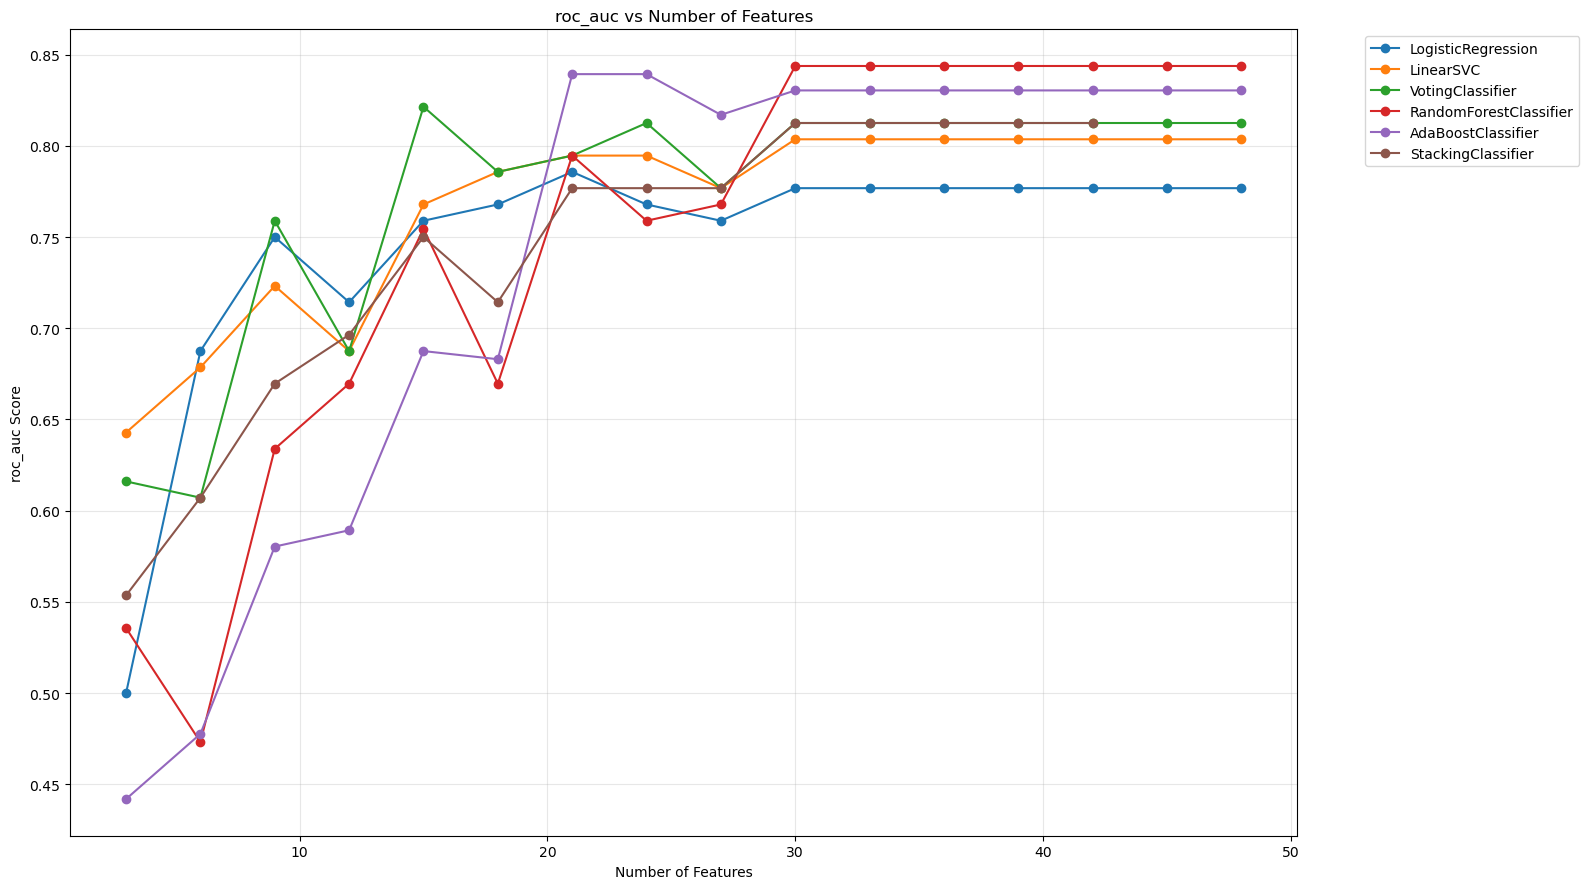

In [ ]:
import matplotlib.pyplot as plt

model_feature_results = pd.read_excel("model_optimum_features_v2.xlsx")

peaks = {}

def plot_metric_vs_feats(model_feature_results, metric):
    plt.figure(figsize=(16, 9))  # Set a good figure size
    model_names = model_feature_results["name"].unique()

    if metric not in model_feature_results.columns:
        print(f"{metric} doesnt exist")
        return

    for name in model_names:
        curr_model_rows = model_feature_results[model_feature_results["name"] == name]
        curr_model_rows = curr_model_rows.sort_values(by="number_of_features", ascending=True)

        
        model_feats_count = curr_model_rows["number_of_features"].values
        model_roc_results = curr_model_rows[metric].values
        
        peak = curr_model_rows[curr_model_rows[metric] == np.max(curr_model_rows[metric].values)]
        print(f"peak {metric} of {name} : ", peak[metric].values[0], "on", peak["number_of_features"].values[0])
        # Add label parameter to identify each model
        plt.plot(model_feats_count, model_roc_results, 'o-', label=name)

    # Add labels and legend
    plt.xlabel("Number of Features")
    plt.ylabel(f"{metric} Score")
    plt.title(f"{metric} vs Number of Features")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
    plt.grid(True, alpha=0.3)
    plt.tight_layout()  # Adjust layout to prevent label cutoff

    plt.show()

# Display the data
plot_metric_vs_feats(model_feature_results, "roc_auc")

In [ ]:
model_feature_count_map = {
    "LogisticRegression" : 21, 
    "LinearSVC" : 30, 
    "VotingClassifier" : 15, 
    "StackingClassifier" : 30, 
    "AdaBoostClassifier" : 30, 
    "RandomForestClassifier" : 30
}

In [ ]:
chemo_columns

['chemo_Cisplatin_doxorubicin_Mitomycin-C', 'chemo_doxorubicin_LC_beads']

In [ ]:
random_test_seeds = [8,32,70,54,55,94,43,86] #generated from np random
#47, 48

In [ ]:
for rand_state in random_test_seeds:
    print(rand_state)

32
47
70
48
54
55
94
43
86
62


15

In [395]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, average_precision_score, accuracy_score, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import is_classifier

split_history = {
    'accuracy': [],
    'roc': [],
    'auc_prc': [],
    'f1': [],
    'precision': [],
    'sensitivity': [],
    'recall': [],
    'specificity': []
}

# 6. --- UNBIASED THRESHOLD DETERMINATION (ON TRAINING DATA) ---
# Find the optimal threshold based ONLY on the training data (y_tr_split, y_prob_tr).
# youden_j_train, optimal_threshold = calculate_youden_j_and_threshold(y_tr, y_prob_tr)

# 7. --- UNBIASED PREDICTIONS (ON TEST DATA) ---
# Apply the training-derived threshold to the test set scores.
current_model_grid = stacking_grid
optimal_feature_num = model_feature_count_map[current_model_grid.estimator.__class__.__name__]
used_features = features[:optimal_feature_num] + chemo_columns # Creates a new list

for rand_state in random_test_seeds:
    # Split the data
    X_tr, X_ts, y_tr, y_ts = train_test_split_patients(
        df, 
        identifier="TCIA_ID", 
        endpoint="responder",  
        test_ratio=train_test_ratio, 
        random_state=rand_state,
    )
    # Create and fit pipeline
    pipeline = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("scale", StandardScaler())
    ])

    # Transform features
    x_cols = X_tr.columns
    X_tr = pipeline.fit_transform(X_tr)
    X_ts = pipeline.transform(X_ts)
    X_tr = pd.DataFrame(X_tr, columns=x_cols)
    X_ts = pd.DataFrame(X_ts, columns=x_cols)
    current_model_grid.fit(X_tr[used_features], y_tr)    

    # Get the best estimator
    est = current_model_grid.best_estimator_
    
    # Try predict_proba first, if not available use decision_function
    try:
        y_prob = est.predict_proba(X_ts[used_features])[:, 1]
    except (AttributeError, IndexError):
        try:
            y_prob = est.decision_function(X_ts[used_features])
        except (AttributeError, IndexError) as e:
            raise RuntimeError("Model doesn't have predict_proba or decision_function methods") from e

    optimal_threshold = 0.5
    y_pred = (y_prob > optimal_threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_ts, y_pred).ravel()

    # Calculate specificity
    specificity = tn / (tn + fp)

    # Calculate metrics
    roc = roc_auc_score(y_ts, y_prob)
    auc = average_precision_score(y_ts, y_prob)
    accuracy = accuracy_score(y_ts, y_pred)
    f1 = f1_score(y_ts, y_pred, pos_label=1)
    precision = precision_score(y_ts, y_pred, pos_label=1)
    recall_val = recall_score(y_ts, y_pred, pos_label=1)

    # Store metrics
    split_history['roc'].append(roc)
    split_history['auc_prc'].append(auc)
    split_history['accuracy'].append(accuracy)
    split_history['f1'].append(f1)
    split_history['precision'].append(precision)
    split_history['recall'].append(recall_val)
    split_history['specificity'].append(specificity)

    # Print iteration results
    print(f"\n--- Random State: {rand_state} ---")
    print(classification_report(y_ts, y_pred))
    print(f"ROC AUC score: {roc:.4f}")
    print(f"Average precision score: {auc:.4f}")

# Calculate and print averages
averages = {metric: np.mean(values) for metric, values in split_history.items()}

# Print formatted averages
print("\n--- Final Averages ---")
for metric, avg in averages.items():
    print(f"{metric.upper()}: {avg:.4f}")

# Calculate and print standard deviations
stds = {metric: np.std(values) for metric, values in split_history.items()}
print("\n--- Standard Deviations ---")
for metric, std in stds.items():
    print(f"{metric.upper()}: {std:.4f}")

Train Set Patient Count: 52
Test Set Patient Count: 23
Train Set Endpoint Distribution:
responder
0.0    0.673077
1.0    0.326923
Name: proportion, dtype: float64
Test Set Endpoint Distribution:
responder
0.0    0.695652
1.0    0.304348
Name: proportion, dtype: float64
Fitting 15 folds for each of 20 candidates, totalling 300 fits

--- Random State: 8 ---
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91        16
         1.0       0.83      0.71      0.77         7

    accuracy                           0.87        23
   macro avg       0.86      0.83      0.84        23
weighted avg       0.87      0.87      0.87        23

ROC AUC score: 0.8750
Average precision score: 0.8547
Train Set Patient Count: 52
Test Set Patient Count: 23
Train Set Endpoint Distribution:
responder
0.0    0.673077
1.0    0.326923
Name: proportion, dtype: float64
Test Set Endpoint Distribution:
responder
0.0    0.695652
1.0    0.304348
Name: proportion, dtype:

In [ ]:
np.random.randint(0, 10000, size=5)

array([5628, 9835, 4889, 8936, 6109], dtype=int32)

In [396]:
def append_monte_carlo_results(output_file, model_name, split_history):
    try:
        output_df = pd.read_excel(output_file)
        if output_df.empty:
            output_df = pd.DataFrame()
    except (FileNotFoundError, pd.errors.EmptyDataError):
        output_df = pd.DataFrame()

    # Create a new row with model_name and all metrics from split_history
    new_entry = {
        'model_name': model_name,
        **{key: [np.mean(split_history[key])] for key in split_history}
    }
    
    # Convert to DataFrame
    new_df = pd.DataFrame(new_entry)
    
    # Check if model_name already exists in the output file
    if not output_df.empty and 'model_name' in output_df.columns:
        # Remove the existing entry if it exists
        output_df = output_df[output_df['model_name'] != model_name]
    
    # Concatenate the updated DataFrame with the new entry
    output_df = pd.concat([output_df, new_df], ignore_index=True)
    
    # Save to CSV
    output_df.to_excel(output_file, index=False)
    return output_df



results = append_monte_carlo_results(
    output_file='monte_carlo_results_elasticnet.xlsx',
    model_name=current_model_grid.best_estimator_.__class__.__name__,
    split_history=split_history
)

In [ ]:
averages

{'accuracy': np.float64(0.8315217391304348),
 'roc': np.float64(0.8772321428571428),
 'auc_prc': np.float64(0.812716526004341),
 'f1': np.float64(0.695425407925408),
 'precision': np.float64(0.778125),
 'sensitivity': np.float64(nan),
 'recall': np.float64(0.6428571428571428),
 'specificity': np.float64(0.9140625)}

Figure saved to elasticnet_stacking_model_performance.png


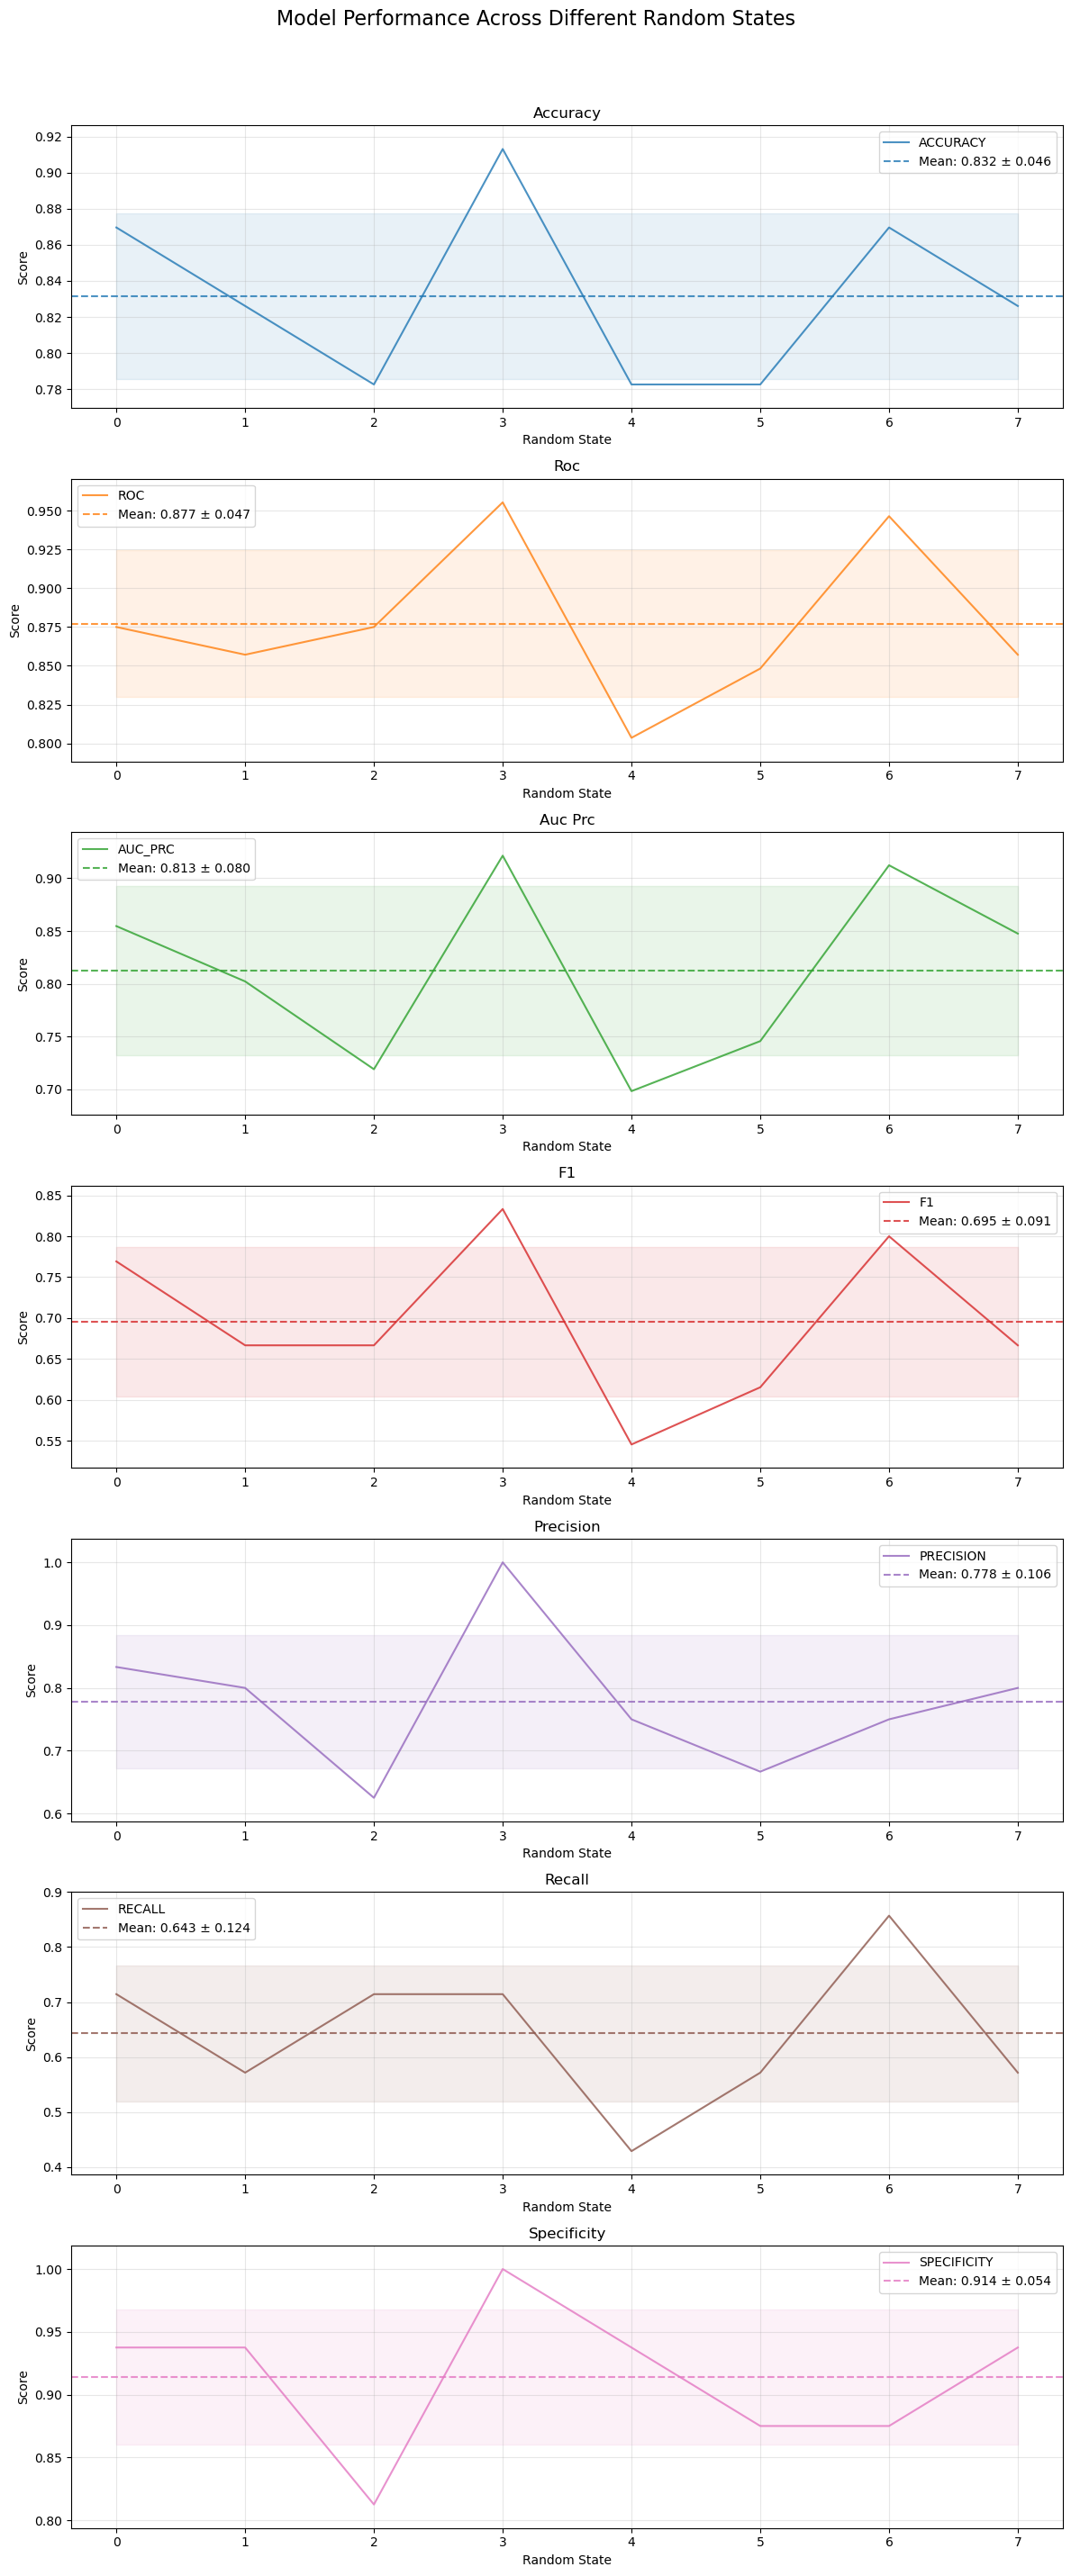

In [397]:
def plot_model_performance(split_history, title='Model Performance Across Different Random States', 
                        figsize=(12, 4), dpi=100, save_path=None, show_std=False,
                         colors=None, line_style='-', mean_line_style='--', 
                         grid_alpha=0.3, legend_loc='best', y_padding=0.1):
    """
    Plot model performance metrics across different random states.
    Skips any empty metrics in the input.
    """
    # Filter out empty metrics
    valid_metrics = {k: v for k, v in split_history.items() if len(v) > 0}
    
    if not valid_metrics:
        print("Warning: No valid metrics to plot!")
        return None
    
    # Default colors if none provided
    if colors is None:
        colors = {
            'accuracy': '#1f77b4', 'roc_auc': '#ff7f0e', 'auc_prc': '#2ca02c',
            'f1': '#d62728', 'precision': '#9467bd', 'recall': '#8c564b',
            'loss': '#e377c2', 'val_loss': '#7f7f7f'
        }
    
    n_metrics = len(valid_metrics)
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_metrics, 1, figsize=(figsize[0], figsize[1] * n_metrics), dpi=dpi)
    fig.suptitle(title, fontsize=16, y=1.02)
    
    # If there's only one metric, axes won't be an array
    if n_metrics == 1:
        axes = [axes]
    
    # Plot each valid metric
    for i, (metric, values) in enumerate(valid_metrics.items()):
        ax = axes[i]
        values = np.array(values)
        x = range(len(values))
        
        # Get color for this metric
        color = colors.get(metric, f'C{i}')
        
        # Plot the metric values
        ax.plot(x, values, line_style, color=color, label=metric.upper(), alpha=0.8)
        
        # Calculate and plot mean and std
        mean_val = np.mean(values)
        std_val = np.std(values)
        
        # Plot mean line
        ax.axhline(y=mean_val, color=color, linestyle=mean_line_style, 
                  label=f'Mean: {mean_val:.3f} ± {std_val:.3f}', alpha=0.8)
        
        # Plot std as shaded area if enabled
        if show_std and len(values) > 1:
            ax.fill_between(x, 
                          mean_val - std_val, 
                          mean_val + std_val, 
                          color=color, 
                          alpha=0.1)
        
        # Customize subplot
        ax.set_title(metric.upper().replace('_', ' ').title())
        ax.set_xlabel('Random State')
        ax.set_ylabel('Score')
        ax.legend(loc=legend_loc)
        ax.grid(True, alpha=grid_alpha)
        
        # Set y-axis limits
        y_min, y_max = np.min(values), np.max(values)
        y_range = y_max - y_min
        y_range = y_range if y_range > 0 else 0.1  # Handle case where min == max
        ax.set_ylim([y_min - y_padding * y_range, y_max + y_padding * y_range])
    
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=dpi)
        print(f"Figure saved to {save_path}")
    
    return fig

fig = plot_model_performance(
    split_history,
    title='Model Performance Across Different Random States',
    # colors={
    #     'accuracy': 'blue',
    #     'f1': 'red',
    #     'precision': 'green',
    #     'recall': 'purple'
    # },
    show_std=True,
    save_path='elasticnet_stacking_model_performance.png'
)
plt.show()

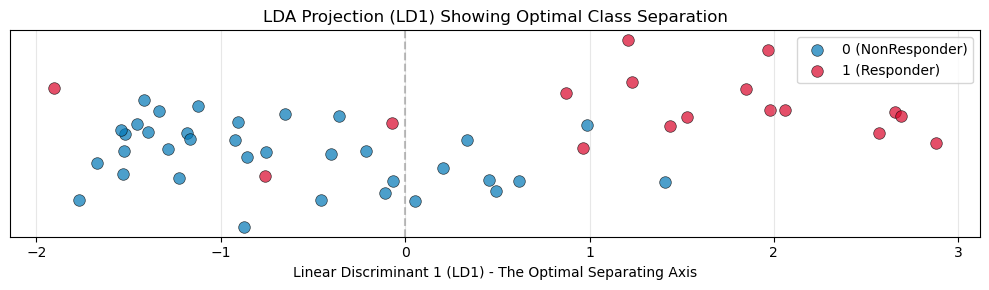

In [ ]:
# Assuming X_tr contains your LASSO-selected features and y_tr contains your class labels.
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA# ----------------------------------------------------
# A. Perform Linear Discriminant Analysis (LDA)
# ----------------------------------------------------
# LDA is supervised and will find the single best axis (LD1) that separates the classes.
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_tr, y_tr)

# ----------------------------------------------------
# B. Visualize the 1D LDA Projection
# ----------------------------------------------------
plt.figure(figsize=(10, 3))

# For a 1D plot, we set the y-axis to a constant (0) to create a line
# and then use a small random jitter (noise) to prevent points from stacking up exactly
# on top of each other, which helps visualize the density.
import numpy as np
y_jitter = np.random.normal(0, 0.05, X_lda.shape[0])

# Plotting Class 0 (NonResponder)
subset_0 = X_lda[y_tr == 0]
plt.scatter(
    subset_0, y_jitter[y_tr == 0],
    c='#0077b6', # A distinct blue color
    label='0 (NonResponder)',
    alpha=0.7,
    s=70,
    edgecolors='k',
    linewidths=0.5
)

# Plotting Class 1 (Responder)
subset_1 = X_lda[y_tr == 1]
plt.scatter(
    subset_1, y_jitter[y_tr == 1] + 0.05, # Shift Class 1 slightly up for better viewing
    c='#d90429', # A distinct red color
    label='1 (Responder)',
    alpha=0.7,
    s=70,
    edgecolors='k',
    linewidths=0.5
)

# ----------------------------------------------------
# C. Final Plot Aesthetics
# ----------------------------------------------------
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5) # Add a vertical line at the origin
plt.title('LDA Projection (LD1) Showing Optimal Class Separation')
plt.xlabel('Linear Discriminant 1 (LD1) - The Optimal Separating Axis')
plt.yticks([]) # Hide the Y-axis ticks, as it's a 1D projection
plt.legend(loc='upper right')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
X_tr

,index,pre-contrast_Liver_original_shape_Elongation,pre-contrast_Liver_original_shape_Flatness,pre-contrast_Liver_original_shape_LeastAxisLength,pre-contrast_Liver_original_shape_MajorAxisLength,pre-contrast_Liver_original_shape_Maximum2DDiameterColumn,pre-contrast_Liver_original_shape_Maximum2DDiameterRow,pre-contrast_Liver_original_shape_Maximum2DDiameterSlice,pre-contrast_Liver_original_shape_Maximum3DDiameter,pre-contrast_Liver_original_shape_MeshVolume,...,pv_Mass_wavelet-LLL_gldm_HighGrayLevelEmphasis,pv_Mass_wavelet-LLL_gldm_LargeDependenceEmphasis,pv_Mass_wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis,pv_Mass_wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,pv_Mass_wavelet-LLL_gldm_LowGrayLevelEmphasis,pv_Mass_wavelet-LLL_gldm_SmallDependenceEmphasis,pv_Mass_wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,pv_Mass_wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,chemo_Cisplatin_doxorubicin_Mitomycin-C,chemo_doxorubicin_LC_beads
0,-1.298665,-2.023639e-02,3.009362e-01,0.087159,-0.472174,-0.949313,-7.209169e-01,-0.404600,0.161481,3.766236e-02,...,-0.074532,-0.380349,-0.294088,-0.221756,-0.302155,0.171259,-0.163237,-0.081753,0.823055,-0.823055
1,-1.257387,8.161238e-01,6.501996e-01,1.443303,0.367060,1.483302,1.761747e+00,0.553838,1.189453,1.341756e+00,...,-0.206198,-0.573230,-0.599958,-0.223121,-0.304684,-0.066887,-0.177974,-0.710792,0.823055,-0.823055
2,-1.216109,1.484378e+00,9.720583e-01,-0.334067,-1.574228,-1.027041,-2.405672e-01,-1.431959,-1.669729,-1.560132e-01,...,-0.697367,-0.254736,-0.531891,-0.207479,-0.171690,-0.534195,-0.694417,0.380623,0.823055,-0.823055
3,-1.133553,9.527573e-16,5.878864e-16,0.000000,0.000000,0.000000,2.229280e-15,0.000000,0.000000,-5.150179e-16,...,0.203480,-0.673841,-0.487882,-0.225831,-0.315483,0.367777,0.255249,-0.623361,0.823055,-0.823055
4,-1.092275,1.318619e+00,8.573494e-01,0.442206,-0.781555,-0.444372,-1.658238e-01,-0.371933,-1.011433,2.314323e-01,...,0.701459,-0.629798,-0.097850,-0.197767,-0.109604,1.238240,0.917606,0.750616,0.823055,-0.823055
5,-1.050998,9.527573e-16,5.878864e-16,0.000000,0.000000,0.000000,2.229280e-15,0.000000,0.000000,-5.150179e-16,...,0.953701,-0.410631,0.400901,-0.226709,-0.331858,0.411552,0.476059,-0.430318,0.823055,-0.823055
6,-1.092275,2.345022e-01,7.948380e-02,-0.116475,-0.393231,0.207898,-1.784040e-01,-0.018711,-0.118129,1.256283e-01,...,0.854705,-0.441475,0.240859,-0.226589,-0.334240,0.216360,0.414332,-0.511652,0.823055,-0.823055
7,-1.050998,-7.431328e-01,-1.550409e+00,-1.942887,0.015800,-0.298090,-1.081862e+00,-0.461365,-0.735675,-1.476744e+00,...,1.676936,0.011947,2.075168,-0.186708,-0.103731,1.381015,0.987151,1.205529,0.823055,-0.823055
8,-1.009720,-4.882241e-01,-2.613209e-01,-1.074990,-0.969241,-1.404422,-1.473809e+00,-1.049157,-1.498316,-1.241702e+00,...,-0.870195,1.918207,0.631644,-0.167726,-0.240767,-1.408853,-0.946009,-0.816559,0.823055,-0.823055
9,-0.927164,1.875978e+00,1.731423e+00,-0.764438,-2.510838,-1.361596,-1.198071e+00,-2.866465,-1.429493,-1.161936e+00,...,1.373251,0.248867,2.406264,-0.198186,-0.301845,0.656213,1.664432,-0.574831,0.823055,-0.823055


In [ ]:
estimator = linear_svc_grid.best_estimator_

y_pred = estimator.predict(x_ts[features])

print(classification_report(y_ts, y_pred))


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
print("Duplicate patient IDs in radiomics_df_final:", radiomics_df_final['TCIA_ID'].duplicated().sum())
print("Duplicate patient IDs in clin_df:", clin_df['TCIA_ID'].duplicated().sum())

Duplicate patient IDs in radiomics_df_final: 0
Duplicate patient IDs in clin_df: 0


In [ ]:
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression

# -----------------------------
# Replace these with your data
# X = your feature matrix
# y = your label vector
# -----------------------------

clf = LogisticRegression(max_iter=5000)
cv = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=5,
    random_state=0
)

# ---- Real score ----
real_scores = cross_val_score(
    clf,
    x_tr,
    y_tr,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

print("Real AUC:", real_scores.mean(), "±", real_scores.std())

# ---- Permuted score ----
y_perm = np.random.permutation(y_tr)

perm_scores = cross_val_score(
    clf,
    x_tr,
    y_perm,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

print("Permuted AUC:", perm_scores.mean(), "±", perm_scores.std())


Real AUC: 0.4138095238095238 ± 0.2352756862195435
Permuted AUC: 0.3861904761904762 ± 0.13686148384274222


In [ ]:
y_ts.value_counts()

responder
0.0    16
1.0     7
Name: count, dtype: int64

Model Tuning(?
)

RFE
